In [1]:
import re

import pandas as pd

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.window import Window

import matplotlib.pyplot as plt
import seaborn as sns

# pip install pycountry-convert
import pycountry_convert as pc

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances

In [2]:
PARQUET_DATA_DIR = f'data/parquets'

In [3]:
spark = SparkSession.builder \
    .master("local") \
    .appName("SpotifyCharts Analiza") \
    .getOrCreate()

In [4]:
# wczytanie danych

# country_distances.csv przygotowuje oddzielny skrypt
country_distances_geo = pd.read_csv("data/country_distances.csv")
spotify_users = pd.read_csv("data/spotify_users.csv", sep=";")

spotify_users['date'] = spotify_users['date'].apply(lambda d: pd.to_datetime(d))
spotify_users['mau'] = 1_000_000 * spotify_users['mau']
spotify_users['mau_premium'] = 1_000_000 * spotify_users['mau_premium']
spotify_users['premium_percent'] = 100 * spotify_users['mau_premium'] / spotify_users['mau']

spotify_users = spotify_users[spotify_users['date'] >= '2016-12-23']

chart_data = spark.read.parquet(f'{PARQUET_DATA_DIR}/chart.parquet').filter(F.col('TrackName') != '').filter(F.col('Artist') != '')
track_data = spark.read.parquet(f'{PARQUET_DATA_DIR}/track_audio_features.parquet').withColumn('album_name', F.regexp_replace(F.col('album_name'), ' \(.*\)', ''))
artist_data = spark.read.parquet(f'{PARQUET_DATA_DIR}/artist.parquet')

In [5]:
chart_data.sample(0.01).show(1)

+-------+----------+--------+-------+----------+--------------------+-------+
|Country|      Date|Position| Artist| TrackName|             TrackID|Streams|
+-------+----------+--------+-------+----------+--------------------+-------+
|     ad|2017-06-09|       9|Shakira|Me Enamoré|4qknM1pQz53QOyfDV...|   1295|
+-------+----------+--------+-------+----------+--------------------+-------+
only showing top 1 row



In [6]:
track_data.sample(0.01).show(1)

+------------+----------+------------------+------------------+------------+------+----------------+--------------------+---+--------+--------+----+-----------+-------+--------------+--------------------+-----------------+-------------+----------------+-------+
|acousticness|album_name|album_release_date|album_release_year|danceability|energy|instrumentalness|             item_id|key|liveness|loudness|mode|speechiness|  tempo|time_signature|     track_artist_id|track_duration_ms|track_explict|track_popularity|valence|
+------------+----------+------------------+------------------+------------+------+----------------+--------------------+---+--------+--------+----+-----------+-------+--------------+--------------------+-----------------+-------------+----------------+-------+
|      0.0751|         3|        2019-10-06|              2019|       0.783| 0.522|         4.67E-6|17wevXT0DwStJFo9L...|  0|   0.138|  -8.196|   1|     0.0329|134.984|             4|0V2DfUrZvBuUReS1L...|          

In [7]:
artist_data.sample(0.01).show(1)

+---------+---------------+--------------------+--------------------+-------+----------+
|followers|          genre|              genres|                  id|   name|popularity|
+---------+---------------+--------------------+--------------------+-------+----------+
|   264254|alternative r&b|[alternative r&b,...|7wFDo161xYdeaiLz3...|Gallant|        62|
+---------+---------------+--------------------+--------------------+-------+----------+
only showing top 1 row



In [8]:
def add_county_continent(df, country_column='Country', continent_column='Continent', country_name_column='Country_name'):
    """
    Funkcja dodaje nazwę państwa oraz nazwę konrynentu do sktóru kraju
    """
    df[continent_column] = df[country_column].apply(lambda s: pc.convert_continent_code_to_continent_name(pc.country_alpha2_to_continent_code(s.upper())))
    df[country_name_column] = df[country_column].apply(lambda s: pc.country_alpha2_to_country_name(s.upper()))
    df = df.sort_values([continent_column, country_name_column]).reset_index(drop=True)
    return df

# Analiza

## Ogólny przegląd

* ile streamów łącznie tydzień po tygodniu

In [9]:
streams_per_week = chart_data \
    .groupBy('Date') \
    .agg(F.sum("Streams").alias("Streams_total")) \
    .sort(F.col('Date').asc()) \
    .toPandas()

streams_per_week['Date'] = streams_per_week['Date'].apply(lambda d: pd.to_datetime(d))

<AxesSubplot:label='03b06540-cc42-433b-bcc4-61518f098b69', xlabel='date', ylabel='mau'>

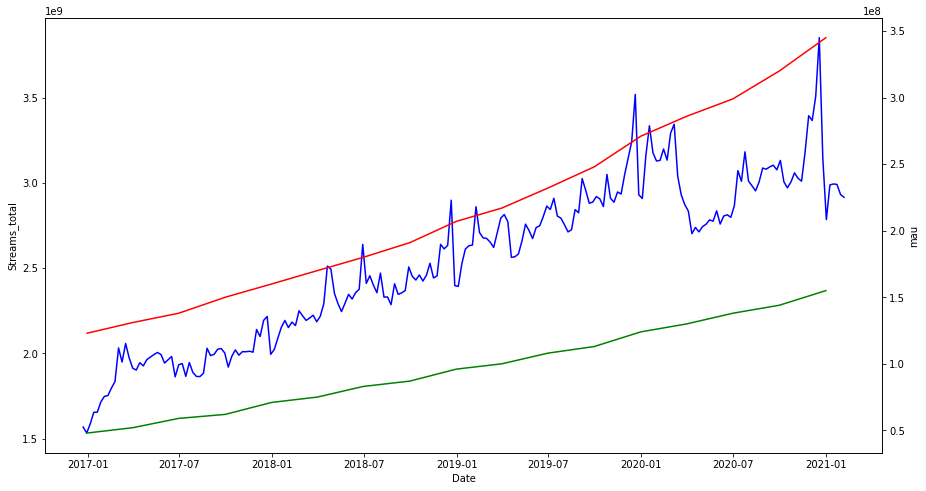

In [10]:
plt.figure(figsize=(15,8))
sns.lineplot(data=streams_per_week, x='Date', y='Streams_total', color='blue')
ax2 = plt.twinx()
sns.lineplot(data=spotify_users, x='date', y='mau', color='red', ax=ax2)
sns.lineplot(data=spotify_users, x='date', y='mau_premium', color='green', ax=ax2)

<AxesSubplot:xlabel='date', ylabel='premium_percent'>

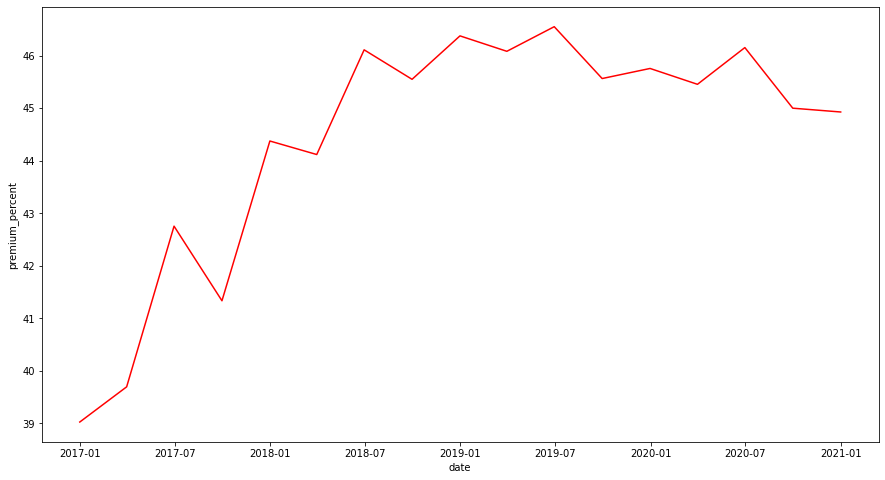

In [11]:
plt.figure(figsize=(15,8))
sns.lineplot(data=spotify_users, x='date', y='premium_percent', color='red')

* rozbicie na kontynenty

In [12]:
streams_per_week_countries = chart_data \
    .groupBy('Date', 'Country') \
    .agg(F.sum("Streams").alias("Streams_total")) \
    .sort(F.col('Date').asc()) \
    .toPandas()

streams_per_week_countries['Date'] = streams_per_week_countries['Date'].apply(lambda d: pd.to_datetime(d))

streams_per_week_countries = add_county_continent(streams_per_week_countries)
streams_per_week_countries = streams_per_week_countries.groupby(['Date', 'Continent']).aggregate('sum').reset_index()

<AxesSubplot:xlabel='Date', ylabel='Streams_total'>

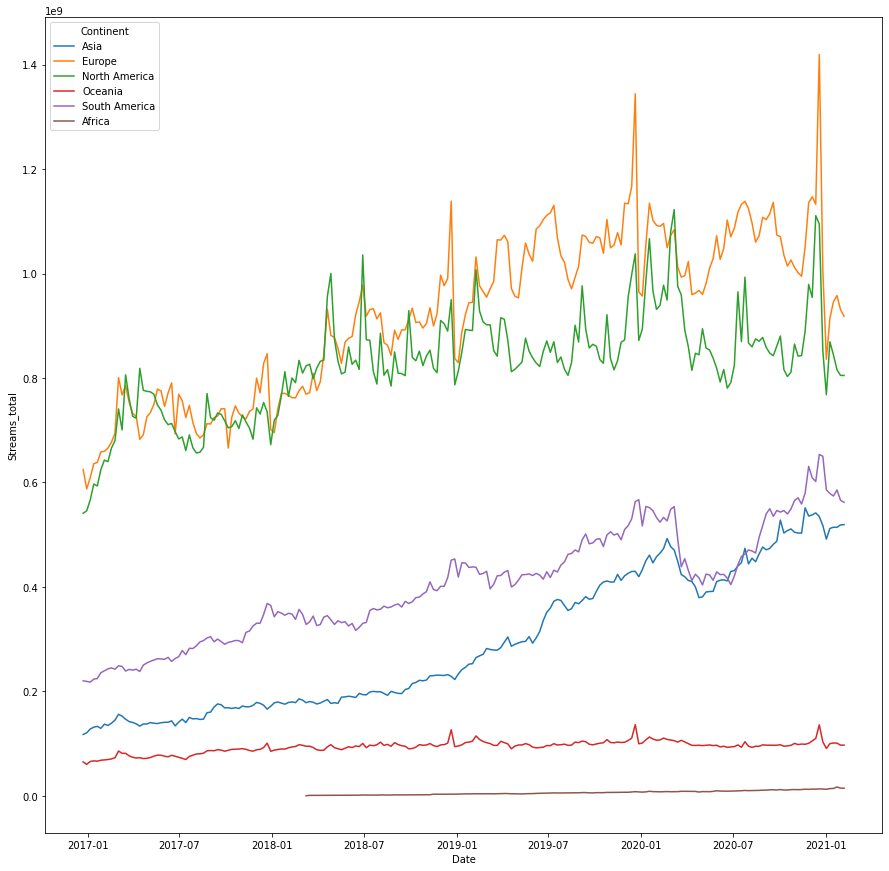

In [13]:
plt.figure(figsize=(15,15))
sns.lineplot(data=streams_per_week_countries, x='Date', y='Streams_total', hue='Continent')

* najpopularniejsi wykonawcy
  * top globalnie na kontynencie

In [14]:
# według globalnej liczby streamów
most_popular_artist = chart_data \
    .groupBy('Artist', 'Country') \
    .agg(F.sum("Streams").alias("Streams_total")) \
    .toPandas()

In [15]:
most_popular_artist = add_county_continent(most_popular_artist)

<AxesSubplot:xlabel='Streams_total', ylabel='Artist'>

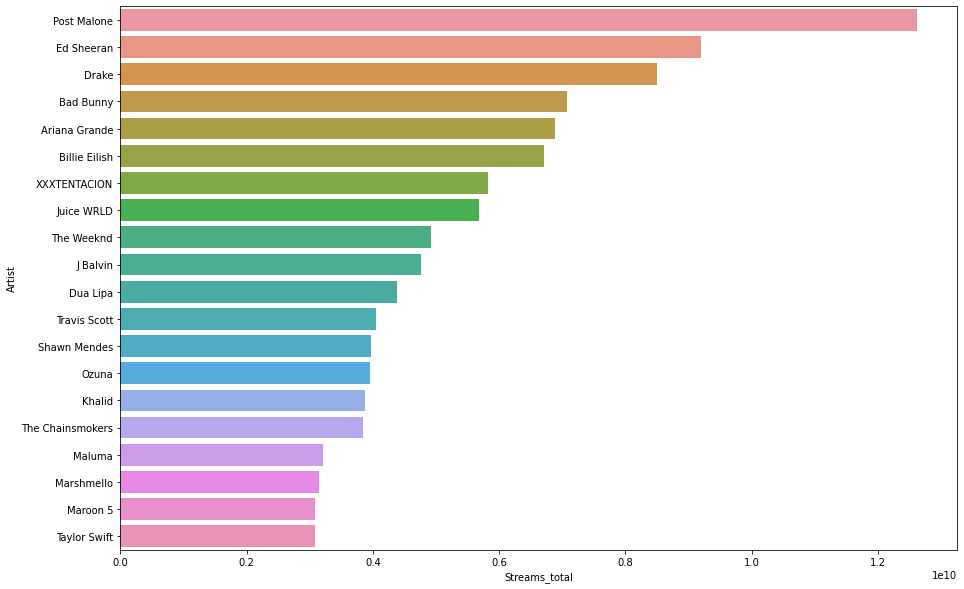

In [16]:
most_popular_artist_global = most_popular_artist.groupby('Artist').aggregate({"Streams_total": 'sum'}).reset_index().sort_values('Streams_total', ascending=False).head(20)

plt.figure(figsize=(15,10))
sns.barplot(data=most_popular_artist_global, x='Streams_total', y='Artist')

In [17]:
# gdzie kogo słucha się najwięcej?
most_popular_artist_continent_tmp = most_popular_artist.groupby(['Continent', 'Artist']).aggregate({"Streams_total": 'sum'}).reset_index().sort_values('Streams_total', ascending=False)

most_popular_artist_continent = pd.DataFrame()

for gname, gdf in most_popular_artist_continent_tmp.groupby('Continent'):
    gdf['Continent'] = gname
    gdf = gdf.sort_values('Streams_total', ascending=False).head(10)
    most_popular_artist_continent = most_popular_artist_continent.append(gdf)
    

<AxesSubplot:xlabel='Streams_total', ylabel='Artist'>

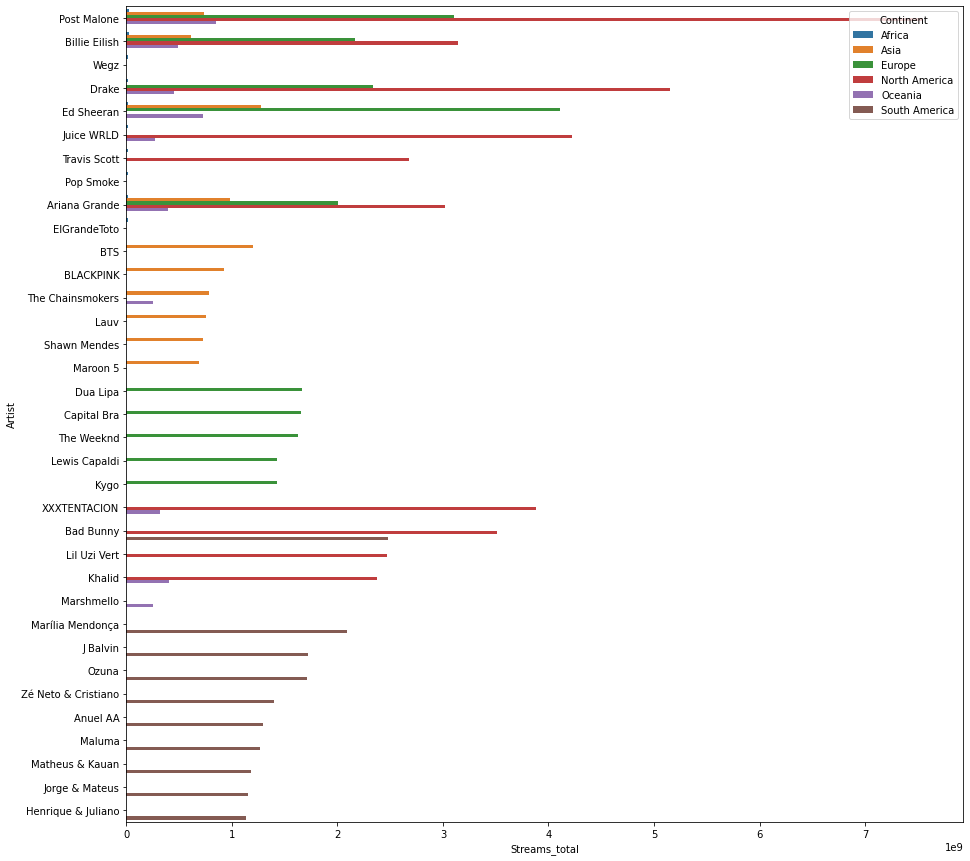

In [18]:
plt.figure(figsize=(15,15))
sns.barplot(data=most_popular_artist_continent, x='Streams_total', y='Artist', hue='Continent')

In [19]:
# według liczby razy na pierwszym miejscu
most_popular_artist_top = chart_data \
    .filter(F.col('Position') == 1) \
    .select('Date', 'Artist', 'Country') \
    .sort('Date', 'Artist') \
    .toPandas()

most_popular_artist_top = add_county_continent(most_popular_artist_top)

most_popular_artist_top['j'] = 1
most_popular_artist_top['n_countries'] = most_popular_artist_top.groupby(['Date', 'Artist'])['j'].transform('sum')
most_popular_artist_top['percent'] = most_popular_artist_top['n_countries'] / sum(most_popular_artist_top['j'])

<AxesSubplot:xlabel='percent', ylabel='Artist'>

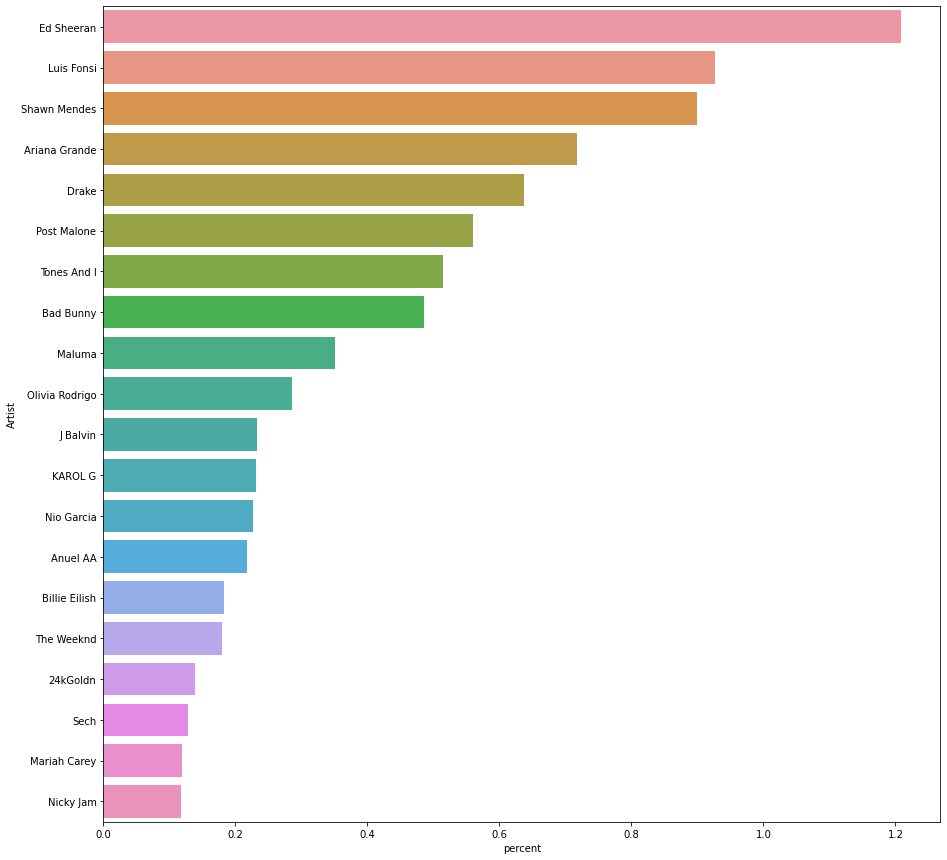

In [20]:
most_popular_artist_top_global = most_popular_artist_top.groupby('Artist').aggregate({"percent": 'sum'}).reset_index().sort_values('percent', ascending=False).head(20)

plt.figure(figsize=(15,15))
sns.barplot(data=most_popular_artist_top_global, x='percent', y='Artist')

In [21]:
most_popular_artist_top_continent_tmp = most_popular_artist_top.groupby(['Continent', 'Artist']).aggregate({"percent": 'sum'}).reset_index().sort_values('percent', ascending=False)

most_popular_artist_top_continent = pd.DataFrame()

for gname, gdf in most_popular_artist_top_continent_tmp.groupby('Continent'):
    gdf['Continent'] = gname
    gdf = gdf.sort_values('percent', ascending=False).head(10)
    most_popular_artist_top_continent = most_popular_artist_top_continent.append(gdf)
    

<AxesSubplot:xlabel='percent', ylabel='Artist'>

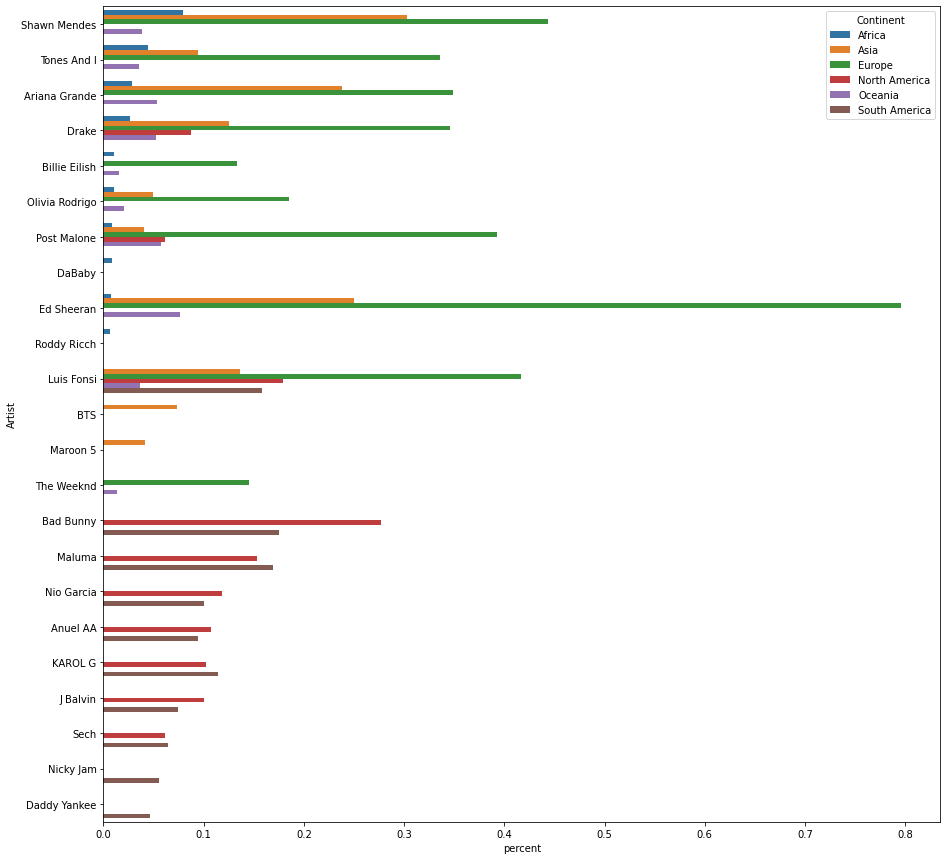

In [22]:
plt.figure(figsize=(15,15))
sns.barplot(data=most_popular_artist_top_continent, x='percent', y='Artist', hue='Continent')

* popularność gatunków (wg streamów)
  * jak zmieniała się popularność gatunków?

In [99]:
# najpopularniejsze wg streamów gatunki w czasie
most_popular_genres_sp = chart_data \
    .select(['Date', 'TrackID', 'Streams', 'Artist']) \
    .join(track_data.select(['item_id', 'track_artist_id']), chart_data['TrackID'] == track_data['item_id']) \
    .join(artist_data.select(['id', 'genre']), track_data['track_artist_id'] == artist_data['id']) \
    .filter(F.col('genre') != '[]') \
    .groupBy(['Date', 'genre', 'Artist']) \
    .agg(F.sum("Streams").alias("Streams_per_genre")) \
    .sort(F.col('Date').asc(), F.col('Streams_per_genre').desc())

most_popular_genres = most_popular_genres_sp.toPandas()
most_popular_genres['Date'] = pd.to_datetime(most_popular_genres['Date'])

# mapowanie podgatunków do większych grup
di = dict()
genres_dict = ['alternative', 'metal', 'dance', 'pop', 'jazz', 'rock', 'hip hop', 'rap', 'r&b', 'soul', 'reggae', 
              'punk', 'classical', 'indie', 'folk', 'house']
for d in most_popular_genres['genre']:
    z = False
    for g in genres_dict:
        if d.lower().find(g) != -1:
            di[d] = g
            z = True
    if not z:
        di[d] = d

most_popular_genres['big_genre'] = most_popular_genres['genre'].map(di)

most_popular_genres_total = most_popular_genres.groupby('big_genre').aggregate({'Streams_per_genre': 'sum'}).reset_index().sort_values('Streams_per_genre', ascending=False)
most_popular_genres_total['percent'] = 100 * most_popular_genres_total['Streams_per_genre'] / (sum(most_popular_genres_total['Streams_per_genre']))


<AxesSubplot:xlabel='percent', ylabel='big_genre'>

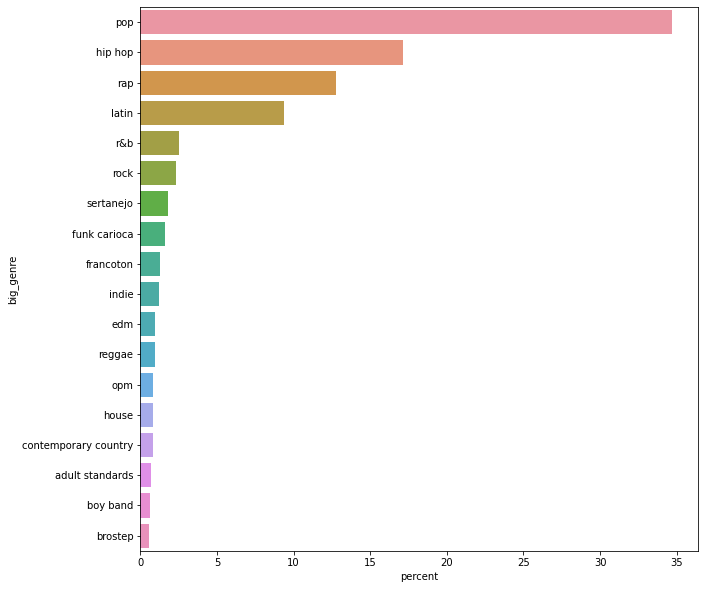

In [24]:
plt.figure(figsize=(10,10))
sns.barplot(data=most_popular_genres_total[most_popular_genres_total['percent'] > 0.5],
           x='percent',
           y='big_genre')

<AxesSubplot:xlabel='percent', ylabel='big_genre'>

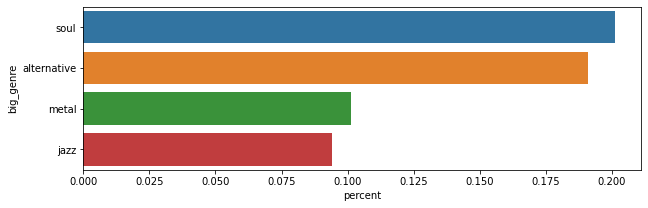

In [25]:
# a gdzie metal, jazz, rock?
plt.figure(figsize=(10,3))
sns.barplot(data=most_popular_genres_total[most_popular_genres_total['big_genre'].isin(['metal', 'jazz', 'alternative', 'soul'])],
           x='percent',
           y='big_genre')

In [26]:
most_popular_genres_total[most_popular_genres_total['big_genre'].isin(['metal', 'classical', 'jazz', 'soul'])]

,big_genre,Streams_per_genre,percent
409,soul,1095033790,0.201089
306,metal,550803438,0.101148
275,jazz,512347750,0.094086
121,classical,2279384,0.000419


jak zmieniała się popularność gatunków w czasie?

<AxesSubplot:xlabel='Date', ylabel='percent'>

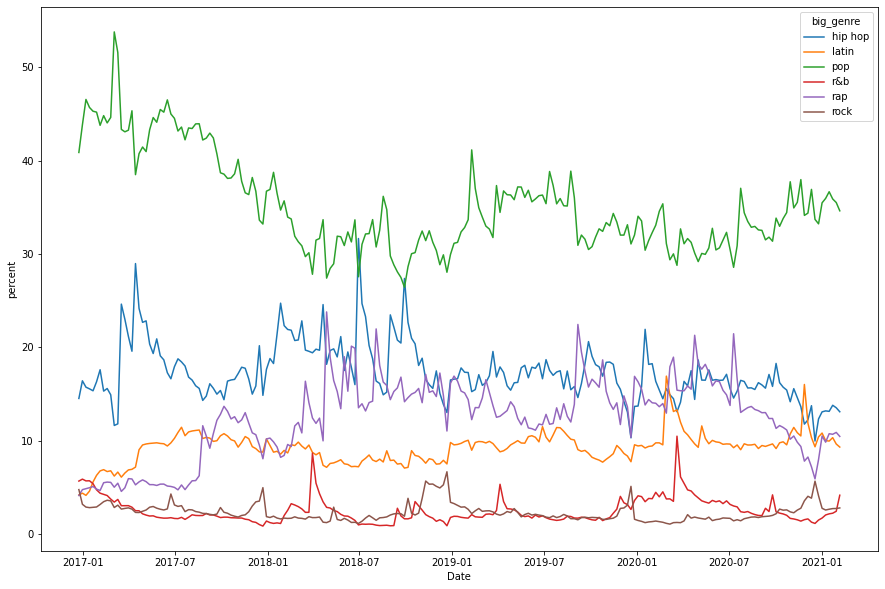

In [27]:
most_popular_genres_big_genres = most_popular_genres.groupby(['Date', 'big_genre']).aggregate({'Streams_per_genre': 'sum'}).reset_index()
most_popular_genres_big_genres['total'] = most_popular_genres_big_genres.groupby('Date')['Streams_per_genre'].transform('sum')
most_popular_genres_big_genres['percent'] = 100 * most_popular_genres_big_genres['Streams_per_genre'] / most_popular_genres_big_genres['total']

plt.figure(figsize=(15,10))
sns.lineplot(data=most_popular_genres_big_genres[most_popular_genres_big_genres['big_genre'].isin(['pop', 'hip hop', 'rap', 'rock', 'latin', 'r&b'])],
             x='Date',
             y='percent',
             hue='big_genre')

In [28]:
most_popular_genres_low = most_popular_genres[most_popular_genres['big_genre'].isin(['metal', 'jazz', 'classical', 'soul'])] \
    .groupby(['big_genre', 'Artist']) \
    .aggregate({'Streams_per_genre': 'sum'}) \
    .reset_index()

most_popular_genres_low_tbl = pd.DataFrame()
for gname, gdf in most_popular_genres_low.groupby('big_genre'):
    gdf['genre'] = gname
    gdf = gdf.sort_values('Streams_per_genre', ascending=False).head(10)
    most_popular_genres_low_tbl = most_popular_genres_low_tbl.append(gdf)
    
most_popular_genres_low_tbl

,big_genre,Artist,Streams_per_genre,genre
1,classical,Fazıl Say,1473539,classical
0,classical,Andrea Bocelli,271645,classical
6,classical,Zbigniew Preisner,167988,classical
3,classical,Jean Sibelius,133924,classical
5,classical,Rikard Nordraak,111577,classical
4,classical,Lars-Erik Larsson,91936,classical
2,classical,Imants Kalniņš,28775,classical
29,jazz,Tulus,159924624,jazz
10,jazz,Ardhito Pramono,124818634,jazz
14,jazz,Glenn Fredly,87039352,jazz


wszystko to sam dla Polski

In [29]:
# najpopularniejsze wg streamów gatunki w czasie
most_popular_genres = chart_data \
    .filter(F.col('Country') == 'pl') \
    .select(['Date', 'TrackID', 'Streams', 'Artist']) \
    .join(track_data.select(['item_id', 'track_artist_id']), chart_data['TrackID'] == track_data['item_id']) \
    .join(artist_data.select(['id', 'genre']), track_data['track_artist_id'] == artist_data['id']) \
    .filter(F.col('genre') != '[]') \
    .groupBy(['Date', 'genre', 'Artist']) \
    .agg(F.sum("Streams").alias("Streams_per_genre")) \
    .sort(F.col('Date').asc(), F.col('Streams_per_genre').desc()) \
    .toPandas()

most_popular_genres['Date'] = pd.to_datetime(most_popular_genres['Date'])

# mapowanie podgatunków do większych grup
di = dict()
genres_dict = ['alternative', 'metal', 'dance', 'pop', 'jazz', 'rock', 'hip hop', 'rap', 'r&b', 'soul', 'reggae', 
              'punk', 'classical', 'indie', 'folk', 'house']
for d in most_popular_genres['genre']:
    z = False
    for g in genres_dict:
        if d.lower().find(g) != -1:
            di[d] = g
            z = True
    if not z:
        di[d] = d
    if d.lower().find('polish alternative') != -1:
        di[d] = d

most_popular_genres['big_genre'] = most_popular_genres['genre'].map(di)

most_popular_genres_total = most_popular_genres.groupby('big_genre').aggregate({'Streams_per_genre': 'sum'}).reset_index().sort_values('Streams_per_genre', ascending=False)
most_popular_genres_total['percent'] = 100 * most_popular_genres_total['Streams_per_genre'] / (sum(most_popular_genres_total['Streams_per_genre']))


<AxesSubplot:xlabel='percent', ylabel='big_genre'>

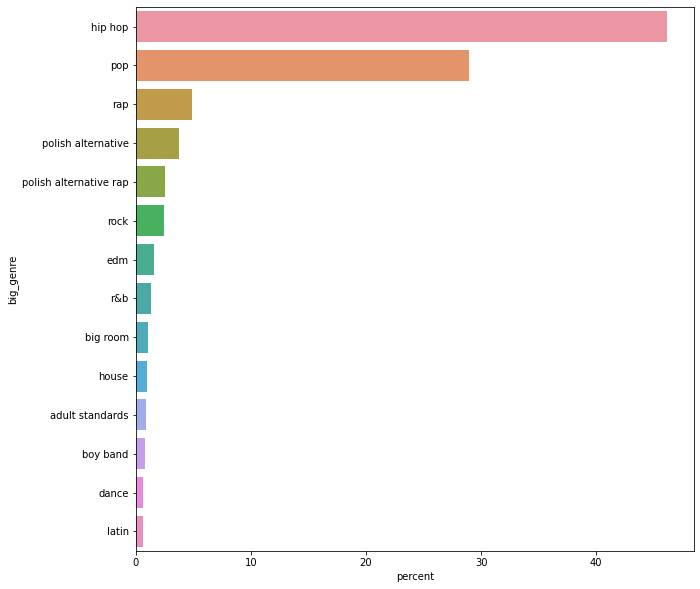

In [30]:
plt.figure(figsize=(10,10))
sns.barplot(data=most_popular_genres_total[most_popular_genres_total['percent'] > 0.5],
           x='percent',
           y='big_genre')

<AxesSubplot:xlabel='percent', ylabel='big_genre'>

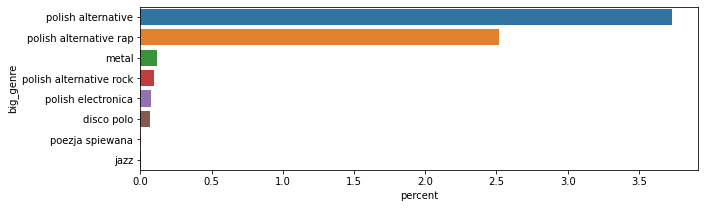

In [31]:
# a gdzie metal, jazz, rock?
plt.figure(figsize=(10,3))
sns.barplot(data=most_popular_genres_total[most_popular_genres_total['big_genre'].isin(['metal', 'jazz', 'alternative', 'poezja spiewana', 'disco polo'])
                                           | most_popular_genres_total['big_genre'].str.contains('polish')],
           x='percent',
           y='big_genre')

In [32]:
most_popular_genres_total[most_popular_genres_total['big_genre'].isin(['metal', 'classical', 'jazz'])]

,big_genre,Streams_per_genre,percent
46,metal,7441826,0.118213
16,classical,167988,0.002668
43,jazz,119180,0.001893


<AxesSubplot:xlabel='Date', ylabel='percent'>

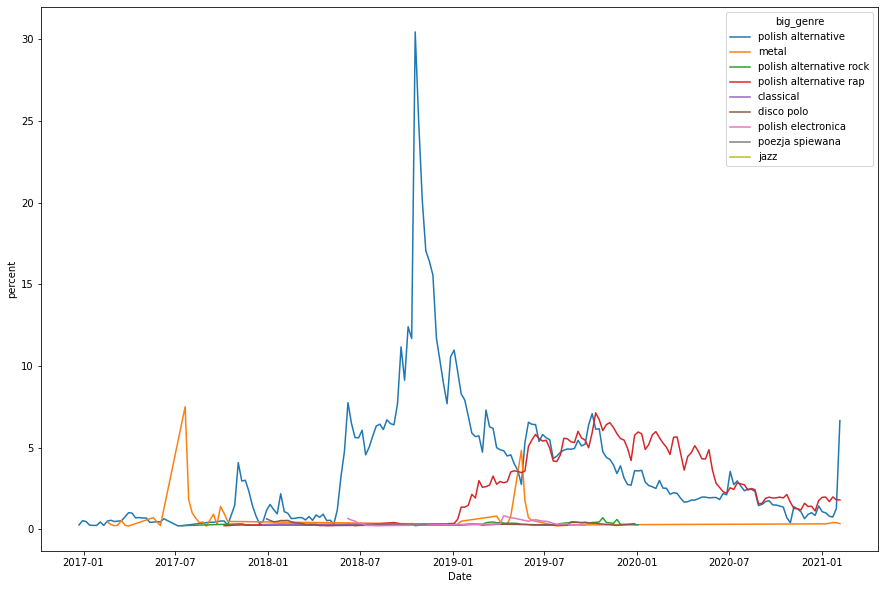

In [33]:
most_popular_genres_big_genres = most_popular_genres.groupby(['Date', 'big_genre']).aggregate({'Streams_per_genre': 'sum'}).reset_index()
most_popular_genres_big_genres['total'] = most_popular_genres_big_genres.groupby('Date')['Streams_per_genre'].transform('sum')
most_popular_genres_big_genres['percent'] = 100 * most_popular_genres_big_genres['Streams_per_genre'] / most_popular_genres_big_genres['total'] 

plt.figure(figsize=(15,10))
sns.lineplot(data=most_popular_genres_big_genres[most_popular_genres_big_genres['big_genre'].isin(['metal', 'jazz', 'alternative',
                                                                                              'poezja spiewana', 'disco polo',
                                                                                              'polish alternative',
                                                                                              'polish alternative rap',
                                                                                              'polish alternative rock',
                                                                                              'polish electronica', 'metal',
                                                                                              'classical', 'jazz', 'disco polo'])],
             x='Date',
             y='percent',
             hue='big_genre')


In [34]:
# hit ostatniego tygodnia w 'polish alternative'
chart_data \
    .filter(F.col('Country') == 'pl') \
    .filter(F.col('Date') >= '2021-01-01') \
    .join(track_data.select(['item_id', 'track_artist_id']), chart_data['TrackID'] == track_data['item_id']) \
    .join(artist_data.select(['id', 'genre']), track_data['track_artist_id'] == artist_data['id']) \
    .filter(F.col('genre') == 'polish alternative') \
    .select(['Date', 'Position', 'TrackName', 'Artist', 'Streams', 'TrackID', ]) \
    .sort(['Date', 'Position']) \
    .toPandas()


,Date,Position,TrackName,Artist,Streams,TrackID
0,2021-01-01,93,Mogło być nic,Kwiat Jabłoni,169468,6XiB2NVxr6QYWSJ6qVLT2p
1,2021-01-01,155,Początek,Męskie Granie Orkiestra 2018,128787,5SPO91s5J85CAxHREvwj3b
2,2021-01-01,160,"Świt (feat. Daria Zawiałow, KRÓL & Igo)",Męskie Granie Orkiestra 2020,126091,6biFi1DYjUd4BkTzViVq4A
3,2021-01-08,107,Mogło być nic,Kwiat Jabłoni,177731,6XiB2NVxr6QYWSJ6qVLT2p
4,2021-01-08,177,"Świt (feat. Daria Zawiałow, KRÓL & Igo)",Męskie Granie Orkiestra 2020,130506,6biFi1DYjUd4BkTzViVq4A
5,2021-01-08,180,Początek,Męskie Granie Orkiestra 2018,128120,5SPO91s5J85CAxHREvwj3b
6,2021-01-15,69,Kaonashi,Daria Zawiałow,240315,1MTK5354Kma6zuRcfIVFhd
7,2021-01-15,132,Mogło być nic,Kwiat Jabłoni,165517,6XiB2NVxr6QYWSJ6qVLT2p
8,2021-01-22,109,Kaonashi,Daria Zawiałow,184736,1MTK5354Kma6zuRcfIVFhd
9,2021-01-22,144,Mogło być nic,Kwiat Jabłoni,164706,6XiB2NVxr6QYWSJ6qVLT2p


In [35]:
most_popular_genres[most_popular_genres['big_genre'].isin(['polish alternative', 'polish alternative rap', 'disco polo','metal', 'jazz', 'poezja spiewana'])] \
    .groupby(['big_genre', 'Artist']) \
    .aggregate({'Streams_per_genre': 'sum'}) \
    .reset_index() \
    .sort_values(['big_genre', 'Streams_per_genre'], ascending=[True, False])

,big_genre,Artist,Streams_per_genre
0,disco polo,Daj To Głośniej,2147829
2,disco polo,Sławomir,1175642
3,disco polo,Łobuzy,634232
1,disco polo,Jacek Stachursky,93470
4,jazz,Pat Metheny,119180
11,metal,Rammstein,3248648
8,metal,Linkin Park,2432108
5,metal,Bring Me The Horizon,862725
7,metal,Foo Fighters,315699
6,metal,Disturbed,229773


In [36]:
# hit ostatniego tygodnia w 'polish alternative'
disco_polo = chart_data \
    .filter(F.col('Country') == 'pl') \
    .join(track_data.select(['item_id', 'track_artist_id']), chart_data['TrackID'] == track_data['item_id']) \
    .join(artist_data.select(['id', 'genre']), track_data['track_artist_id'] == artist_data['id']) \
    .filter(F.col('genre') == 'disco polo') \
    .select(['Date', 'Position', 'TrackName', 'Artist', 'Streams', 'TrackID', ]) \
    .sort(['Date', 'Position']) \
    .toPandas()

disco_polo['Date'] = pd.to_datetime(disco_polo['Date'])
disco_polo['name'] = disco_polo['Artist'] + ' - ' + disco_polo['TrackName']

<AxesSubplot:xlabel='Date', ylabel='Streams'>

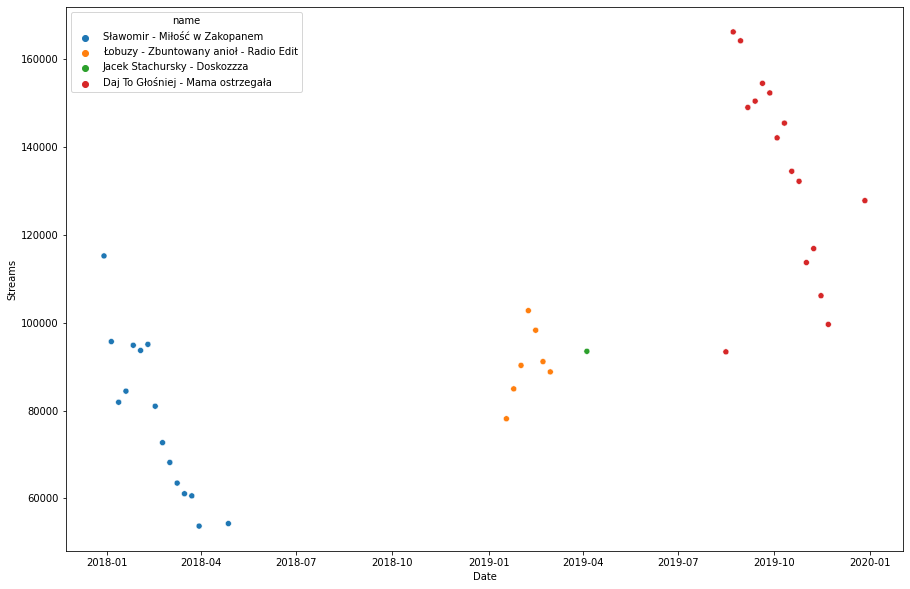

In [37]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=disco_polo, x='Date', y='Streams', hue='name')

* The average number of daily streams received at each position in the Spotify Top 200, plus and minus one standard deviation

In [38]:
streams_per_pos = chart_data \
    .groupBy('Position', 'Country') \
    .agg(F.sum('Streams').alias('total_streams')) \
    .toPandas()

<AxesSubplot:xlabel='Position', ylabel='total_streams'>

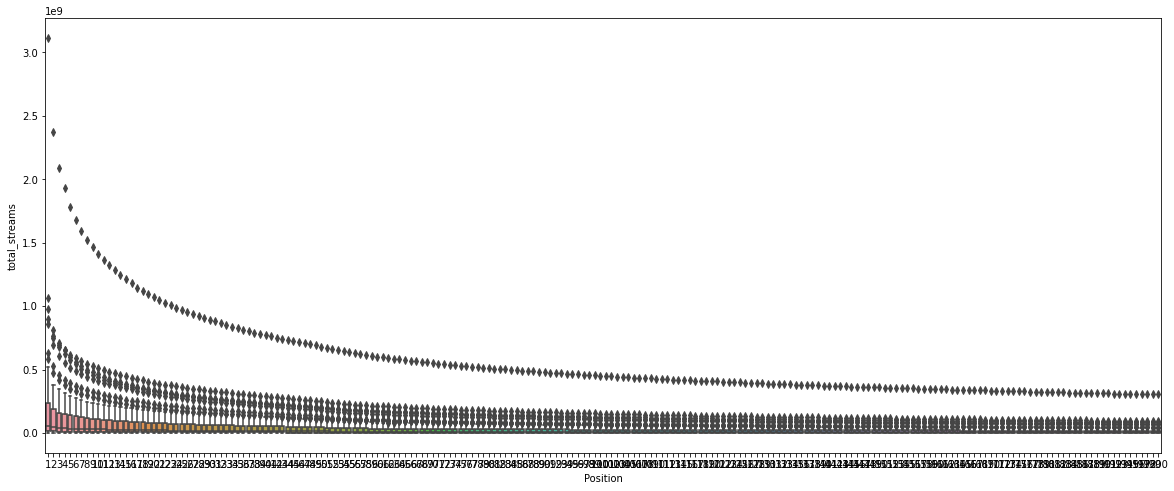

In [39]:
plt.figure(figsize=(20,8))
sns.boxplot(data=streams_per_pos, x='Position', y='total_streams')

* rok wydania utworu a liczba streamów (czy słucha się nowych czy wszystkiego)
  * lata 2017-2021, każda linia osobno

  * lata 2010-2017 - linia dodatkowa

  * potem dekadami kolejne linie

In [40]:
charts_with_tracks = chart_data \
    .join(track_data, chart_data['TrackID'] == track_data['item_id'])

In [41]:
streams_by_date = charts_with_tracks \
    .filter(F.col('album_release_year') != 0) \
    .groupby('Date', 'album_release_year', 'Country') \
    .agg(F.sum('Streams').alias('streams')) \
    .toPandas()

In [42]:
streams_by_date_global = streams_by_date.groupby(['Date', 'album_release_year']).aggregate({'streams': 'sum'}).reset_index()


year_map = dict()
for y in streams_by_date_global['album_release_year'].unique():
    year_map[y] = 10*(y // 10) # dekada
    if y >= 2016:
         year_map[y] = y

streams_by_date_global['decade'] = streams_by_date_global['album_release_year'].map(year_map)
streams_by_date_global['decade'] = streams_by_date_global['decade'].apply(lambda x: str(x))
streams_by_date_global['Date'] = pd.to_datetime(streams_by_date_global['Date'])
streams_by_date_global_plot = streams_by_date_global.groupby(['Date', 'decade']).aggregate({'streams': 'sum'}).reset_index()
streams_by_date_global_plot['streams_per_week'] = streams_by_date_global_plot.groupby('Date')['streams'].transform('sum')
streams_by_date_global_plot['percent'] = 100 * streams_by_date_global_plot['streams']  / streams_by_date_global_plot['streams_per_week'] 

<AxesSubplot:xlabel='Date', ylabel='percent'>

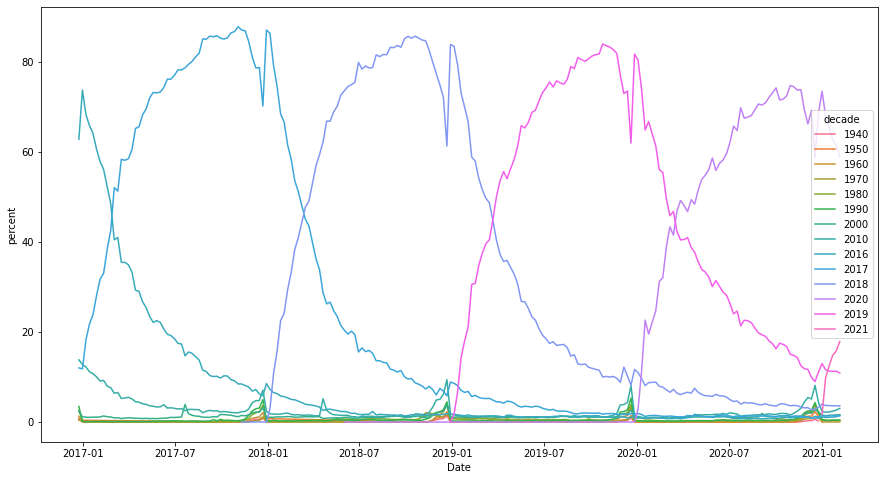

In [43]:
plt.figure(figsize=(15,8))
sns.lineplot(data=streams_by_date_global_plot, x='Date', y='percent', hue='decade')

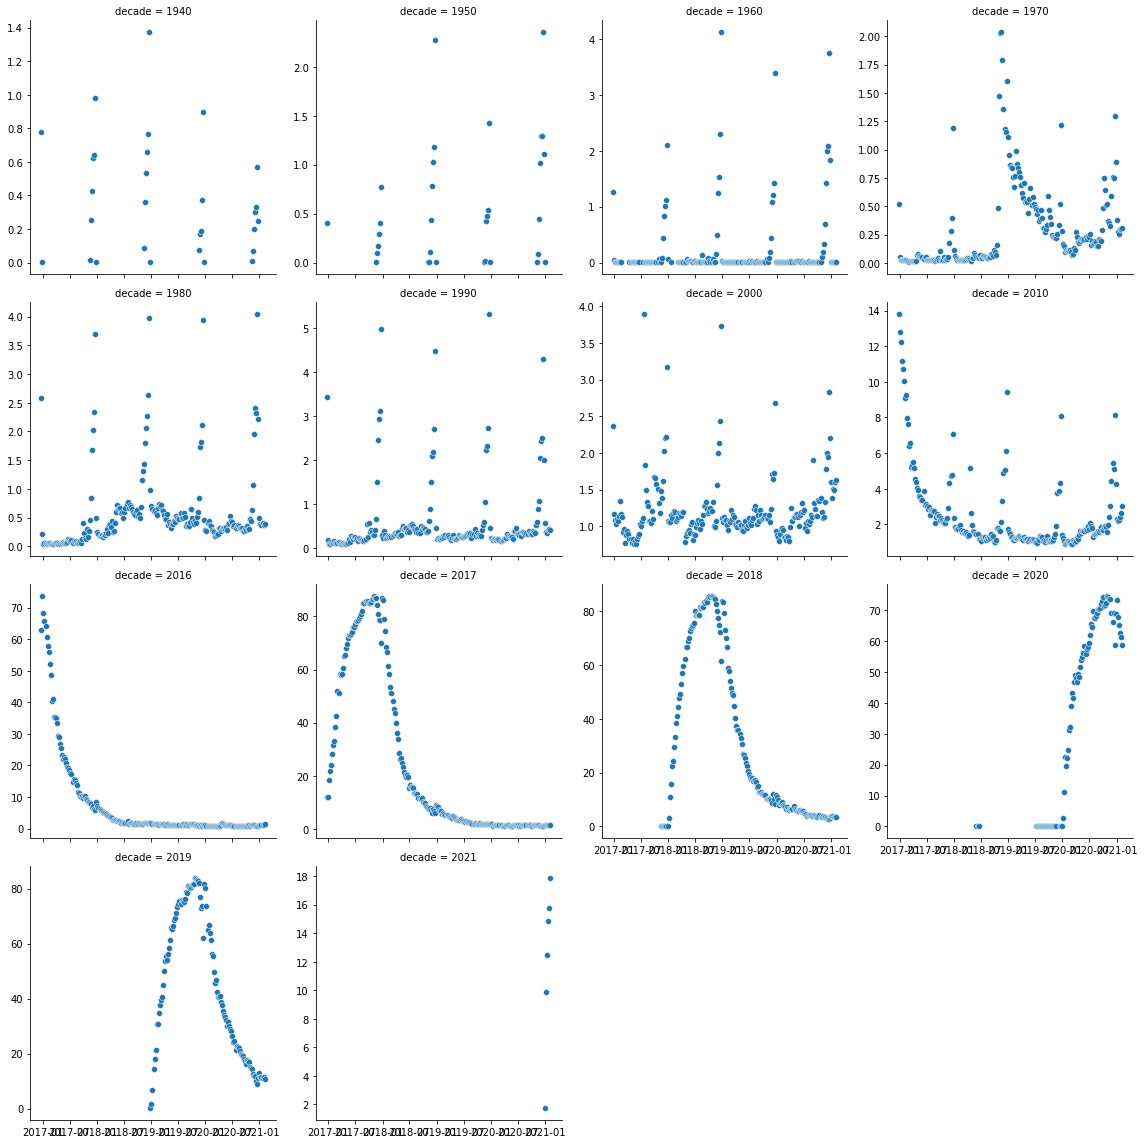

In [44]:
g = sns.FacetGrid(data=streams_by_date_global_plot, col='decade', col_wrap=4, sharey=False, height=4)
g.map_dataframe(sns.scatterplot,  x='Date', y='percent')

In [45]:
# lata 1970 w 2019 - co to za płyty?
seventys_2019 = charts_with_tracks \
    .filter( (F.col('Date') >= '2018-05-01') &  (F.col('Date') <= '2020-07-01') ) \
    .filter( (F.col('album_release_year') >= 1970) &  (F.col('album_release_year') <= 1979) ) \
    .groupBy('Date', 'Artist', 'album_name') \
    .agg(F.sum('Streams').alias('Streams')) \
    .sort(F.col('Streams').desc()) \
    .toPandas()

seventys_2019['Date'] = pd.to_datetime(seventys_2019['Date'])

seventys_2019_plot = pd.DataFrame()

for gn,gdf in seventys_2019.groupby('Date'):
    gdf = gdf.nlargest(2, 'Streams')
    gdf['album_name'] = gdf['album_name'].apply(lambda s: re.sub(r' \(.*\)', "", s))
    gdf['Date'] = gn
    gdf['name'] = gdf['Artist'] + ' - ' + gdf['album_name']
    seventys_2019_plot = seventys_2019_plot.append(gdf)

<AxesSubplot:xlabel='Date', ylabel='Streams'>

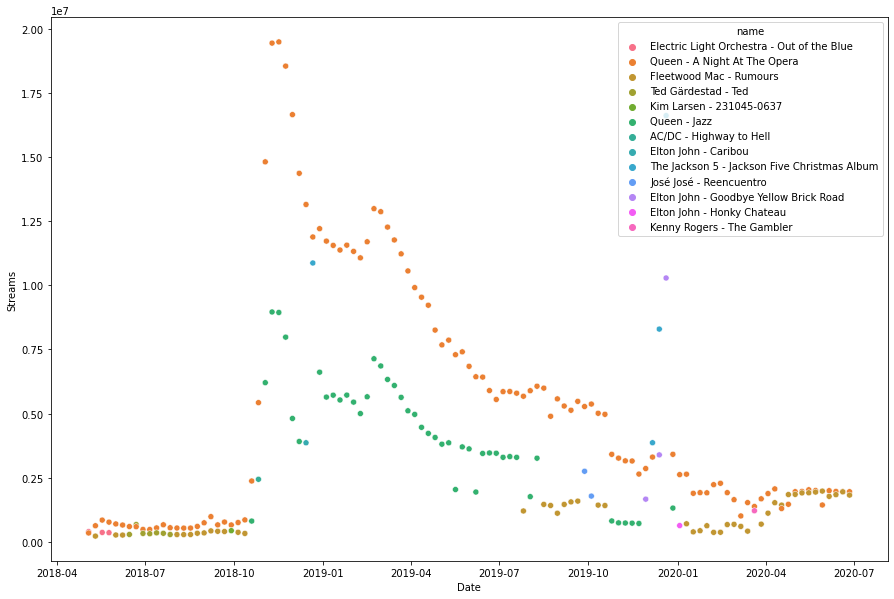

In [46]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=seventys_2019_plot, x='Date', y='Streams', hue='name')

In [47]:
# w październiku 2018 miała miejsce premiera filmu o Queen

### Polska vs reszta świata

* kto w Polsce tobi najwięcej ruchu?

In [48]:
pl_artist = chart_data \
    .filter(F.col('Country') == 'pl') \
    .groupBy('Artist', 'Date') \
    .agg(F.sum('Streams').alias('Streams')) \
    .toPandas()

pl_artist['Date'] = pl_artist['Date'].apply(lambda s: pd.to_datetime(s))
pl_artist['Streams_total'] = pl_artist.groupby('Date')['Streams'].transform('sum')
pl_artist['Streams_percent'] = 100 * pl_artist['Streams'] / pl_artist['Streams_total']
pl_artist['max_percent'] = pl_artist.groupby('Date')['Streams_percent'].transform('max')
pl_artists_by_weeks = pl_artist[pl_artist['Streams_percent'] == pl_artist['max_percent']].groupby('Artist').count().reset_index().sort_values('max_percent', ascending=False)
pl_artists_streams = pl_artist[pl_artist['Artist'].isin(pl_artists_by_weeks.head(20)['Artist'])].groupby('Artist').aggregate({'Streams': 'sum'}).reset_index().sort_values('Streams', ascending=False)

<AxesSubplot:xlabel='Streams', ylabel='Artist'>

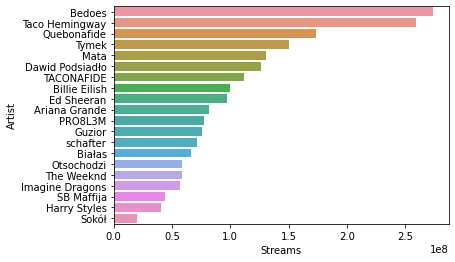

In [49]:
sns.barplot(data=pl_artists_streams, x='Streams', y='Artist')

<AxesSubplot:xlabel='max_percent', ylabel='Artist'>

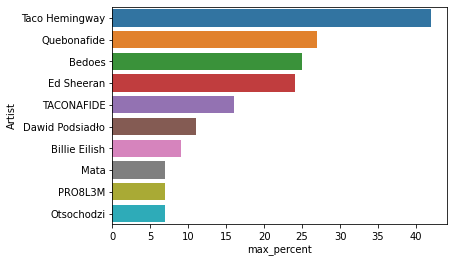

In [50]:
# ile razy na 1 miejscu?
sns.barplot(data=pl_artists_by_weeks.head(10), x='max_percent', y='Artist')

<AxesSubplot:xlabel='Date', ylabel='Streams'>

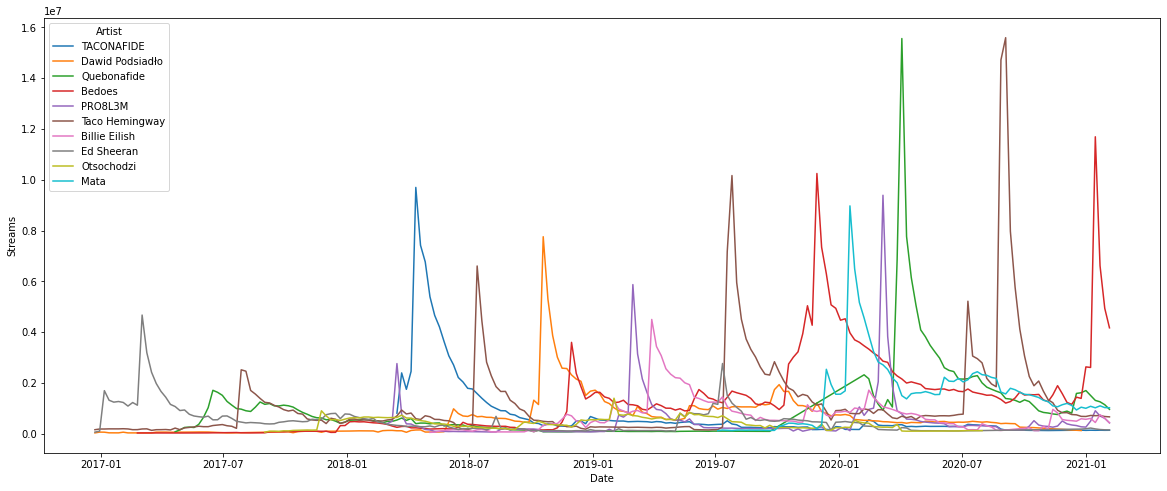

In [51]:
# liczba streamów w czasie - najpopularniejsi
plt.figure(figsize=(20,8))
sns.lineplot(data=pl_artist[pl_artist['Artist'].isin( pl_artists_by_weeks.head(10)['Artist'])], x='Date', y='Streams', hue='Artist')

## Cechy audio

* średnia ważona cech dla kraju po tygodniach

In [52]:
streams_total = chart_data \
    .groupBy('Country', 'Date') \
    .agg(F.sum("Streams").alias("Streams_total"))

chart_data_totals = chart_data \
    .join(streams_total, on=['Country', 'Date'], how='left')

chart_data_totals = chart_data_totals \
    .withColumn('factor', chart_data_totals['Streams']/chart_data_totals['Streams_total'])

chart_data_totals = chart_data_totals \
    .join(track_data, on = chart_data_totals['TrackID']==track_data['item_id'], how='left')

chart_data_totals = chart_data_totals \
    .withColumn('acousticness', chart_data_totals['factor'] * chart_data_totals['acousticness']) \
    .withColumn('danceability', chart_data_totals['factor'] * chart_data_totals['danceability']) \
    .withColumn('energy', chart_data_totals['factor'] * chart_data_totals['energy']) \
    .withColumn('instrumentalness', chart_data_totals['factor'] * chart_data_totals['instrumentalness']) \
    .withColumn('liveness', chart_data_totals['factor'] * chart_data_totals['liveness']) \
    .withColumn('loudness', chart_data_totals['factor'] * chart_data_totals['loudness']) \
    .withColumn('speechiness', chart_data_totals['factor'] * chart_data_totals['speechiness']) \
    .withColumn('tempo', chart_data_totals['factor'] * chart_data_totals['tempo']) \
    .withColumn('valence', chart_data_totals['factor'] * chart_data_totals['valence']) \
    .withColumn('key', chart_data_totals['factor'] * chart_data_totals['key']) \
    .withColumn('mode', chart_data_totals['factor'] * chart_data_totals['mode'])

chart_data_totals_features = chart_data_totals \
    .groupBy('Country', 'Date') \
    .agg( \
        F.sum("acousticness").alias("acousticness"), \
        F.sum("danceability").alias("danceability"), \
        F.sum("energy").alias("energy"), \
        F.sum("instrumentalness").alias("instrumentalness"), \
        F.sum("liveness").alias("liveness"), \
        F.sum("loudness").alias("loudness"), \
        F.sum("speechiness").alias("speechiness"), \
        F.sum("tempo").alias("tempo"), \
        F.sum("valence").alias("valence"), \
        F.sum("key").alias("key"), \
        F.sum("mode").alias("mode") \
    )

In [53]:
chart_data_totals.show(2)

+-------+----------+--------+---------+---------+--------------------+-------+-------------+--------------------+--------------------+----------+------------------+------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+------------------+--------------+--------------------+-----------------+-------------+----------------+--------------------+
|Country|      Date|Position|   Artist|TrackName|             TrackID|Streams|Streams_total|              factor|        acousticness|album_name|album_release_date|album_release_year|        danceability|              energy|    instrumentalness|             item_id|                key|            liveness|            loudness|                mode|         speechiness|             tempo|time_signature|     track_artist_id|track_duration_ms|track_explict|track_popularity|             valence|
+-----

In [54]:
chart_data_totals_features.show(2)

+-------+----------+-------------------+------------------+------------------+--------------------+-------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+
|Country|      Date|       acousticness|      danceability|            energy|    instrumentalness|           liveness|          loudness|        speechiness|             tempo|           valence|              key|              mode|
+-------+----------+-------------------+------------------+------------------+--------------------+-------------------+------------------+-------------------+------------------+------------------+-----------------+------------------+
|     ar|2018-11-09| 0.2335875620552502|0.7194043783728125| 0.713097812166221|0.002218852382874...| 0.1776774925082737|-4.931798866846433|0.11781239494909242| 125.0066221811522|0.5874736840043354|5.669804601116213|0.5381446339858658|
|     ar|2019-12-20|0.22177028979638666|0.7356579315485599|0.705

* popularity vs inne audio features

In [55]:
popularity_features = chart_data_totals \
    .select('track_popularity', 'acousticness', 'album_release_year', 'danceability',
            'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
            'speechiness', 'tempo', 'track_duration_ms', 'valence') \
    .dropDuplicates() \
    .filter(F.col('album_release_year') != 0) \
    .toPandas()

In [56]:
popularity_features = popularity_features.groupby('track_popularity').aggregate('mean').reset_index()

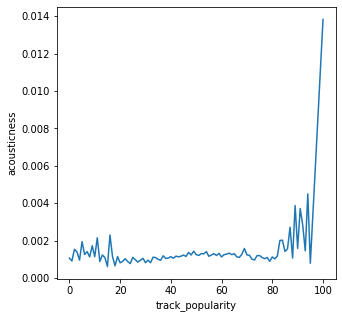

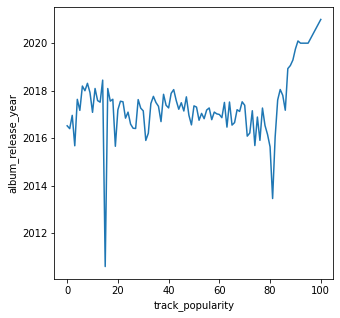

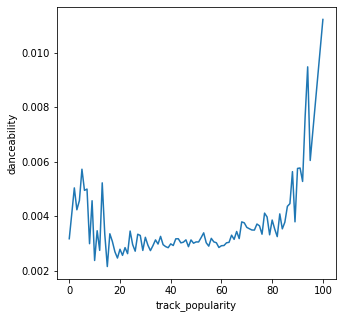

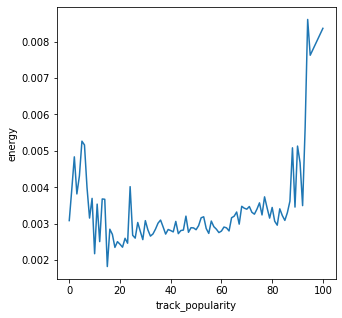

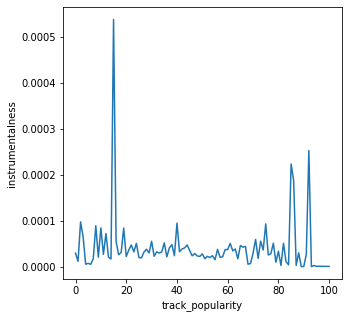

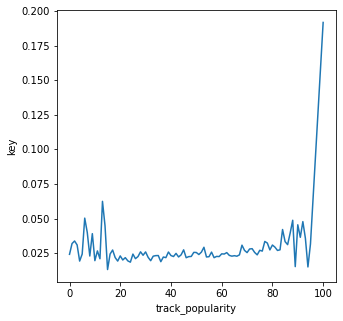

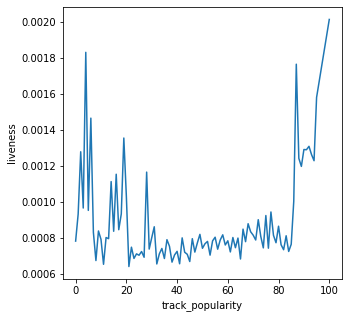

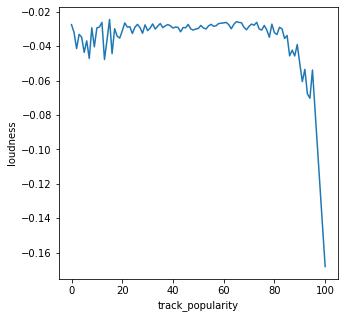

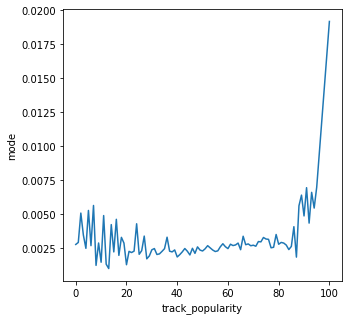

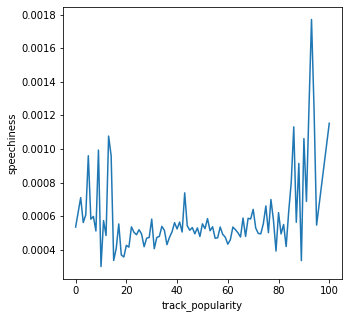

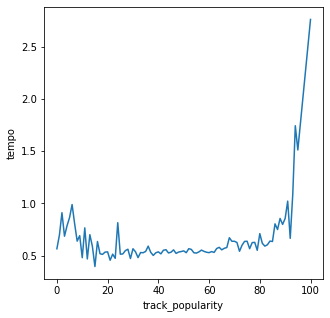

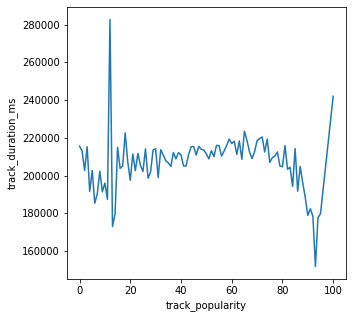

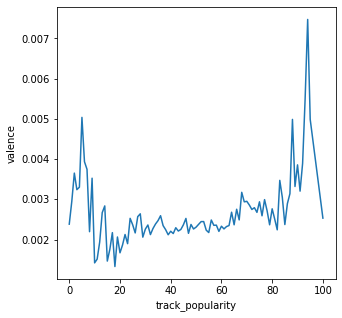

In [57]:
pcols = ['acousticness', 'album_release_year', 'danceability',
         'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
         'speechiness', 'tempo', 'track_duration_ms', 'valence']

for c in pcols:
    plt.figure(figsize=(5,5))
    sns.lineplot(data=popularity_features, x='track_popularity', y=c)
    plt.show()

### Podobieństwo państw na pdstawie cech

* uśredniony wektor cech dla państwa - globalnie

In [58]:
country_mean_features = chart_data_totals_features \
    .groupBy('Country') \
    .agg(
        F.mean('acousticness').alias('mean_acousticness'),
        F.mean('danceability').alias('mean_danceability'),
        F.mean('energy').alias('mean_energy'),
        F.mean('instrumentalness').alias('mean_instrumentalness'),
        F.mean('liveness').alias('mean_liveness'),
        F.mean('loudness').alias('mean_loudness'),
        F.mean('speechiness').alias('mean_speechiness'),
        F.mean('tempo').alias('mean_tempo'),
        F.mean('valence').alias('mean_valence'),
        F.mean('key').alias('mean_key'),
        F.mean('mode').alias('mean_mode')
     ) \
    .toPandas()


In [59]:
country_mean_features

,Country,mean_acousticness,mean_danceability,mean_energy,mean_instrumentalness,mean_liveness,mean_loudness,mean_speechiness,mean_tempo,mean_valence,mean_key,mean_mode
0,cr,0.229932,0.727925,0.683776,0.003136,0.156784,-5.125301,0.116777,122.633382,0.602355,5.375326,0.588345
1,us,0.220630,0.712445,0.597959,0.007450,0.168841,-6.618945,0.141137,122.384967,0.460201,5.316360,0.576010
2,eg,0.286645,0.697117,0.636016,0.014651,0.167064,-6.771727,0.111860,120.591385,0.508648,5.350111,0.402351
3,cl,0.225599,0.742322,0.714888,0.002757,0.160101,-4.869628,0.118543,122.826901,0.622748,5.411257,0.558782
4,il,0.310907,0.667462,0.595662,0.008432,0.170594,-6.598863,0.092052,118.290218,0.480865,5.583024,0.429289
...,...,...,...,...,...,...,...,...,...,...,...,...
64,se,0.261601,0.661629,0.621524,0.006538,0.164834,-6.726023,0.107587,117.362448,0.492450,5.299933,0.592010
65,ie,0.227261,0.670400,0.642066,0.009077,0.163278,-6.182371,0.099904,118.600378,0.500331,5.304823,0.600150
66,dk,0.226014,0.705748,0.627979,0.004933,0.159170,-6.271268,0.114199,117.693684,0.520526,5.374935,0.496542
67,id,0.376747,0.620325,0.554227,0.009201,0.156204,-6.927861,0.064661,116.479726,0.452244,5.219015,0.708588


In [71]:
cossim = pd.DataFrame(cosine_similarity(country_mean_features.drop('Country', axis=1))).reset_index(drop=True)
cossim.columns = country_mean_features['Country']
cossim['Country'] = country_mean_features['Country']

cossim_df = cossim.melt(id_vars='Country', var_name='Country2', value_name='sim')
cossim_df = cossim_df[cossim_df['Country'] != cossim_df['Country2']]

cossim_df = add_county_continent(cossim_df, country_column='Country')
cossim_df = add_county_continent(cossim_df, country_column='Country2', continent_column='Continent2', country_name_column='Country2_name')

cossim_df['Country'] = cossim_df['Country'].str.upper()
cossim_df['Country2'] = cossim_df['Country2'].str.upper()


<AxesSubplot:xlabel='None-Continent2', ylabel='Continent'>

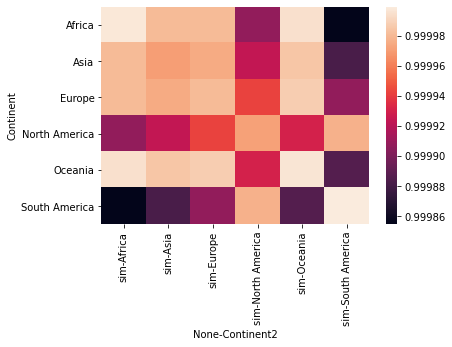

In [72]:
sns.heatmap(cossim_df.pivot_table(index='Continent', columns='Continent2'))

<AxesSubplot:xlabel='sim', ylabel='Country2_name'>

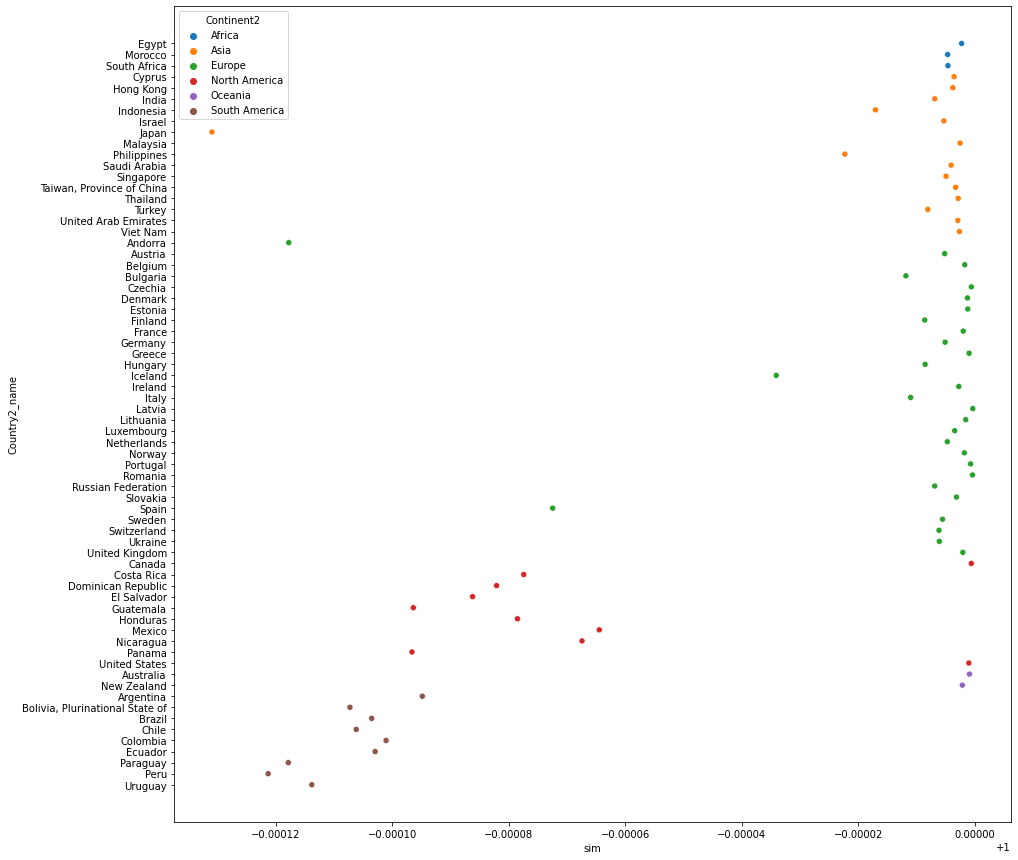

In [73]:
plt.figure(figsize=(15,15))
sns.scatterplot(data=cossim_df[cossim_df['Country'] == 'PL'].sort_values(['Continent2', 'Country2_name']),
                x='sim', y='Country2_name', hue='Continent2')

* odległość krajów od siebie - odległość środków państw a odległość kosinusowa po cechach 

In [91]:
cossim_small = cossim_df[['Country', 'Country2', 'sim']]

cossim_small = cossim_small[cossim_small['Country'] > cossim_small['Country2']]

cossim_small['pair'] = cossim_df['Country'] + cossim_df['Country2']

country_distances_geo['pair'] = country_distances_geo['from'] + country_distances_geo['to']
country_distances_geo['pair'] = country_distances_geo['pair'].str.upper()

cossim_small = country_distances_geo.merge(cossim_small, left_on='pair', right_on='pair')

cossim_small = cossim_small[['from', 'to', 'distance', 'sim']]

cossim_small = add_county_continent(cossim_small, country_column='from', continent_column='from_cont', country_name_column='from_name')
cossim_small = add_county_continent(cossim_small, country_column='to', continent_column='to_cont', country_name_column='to_name')
# cossim_small = cossim_small[cossim_small['from_cont'] != cossim_small['to_cont']]
cossim_small['cont_pair'] = cossim_small['from_cont'] + ' - ' + cossim_small['to_cont']


In [92]:
cossim_small[(cossim_small['from_cont'] == 'Europe') & (cossim_small['to_cont'] == 'Europe')].sort_values('sim')

,from,to,distance,sim,from_cont,from_name,to_cont,to_name,cont_pair
1140,IS,ES,2798.318118,0.999796,Europe,Iceland,Europe,Spain,Europe - Europe
1152,SE,ES,2730.565106,0.999886,Europe,Sweden,Europe,Spain,Europe - Europe
1153,UA,ES,2932.336506,0.999893,Europe,Ukraine,Europe,Spain,Europe - Europe
1144,LT,ES,2641.427175,0.999909,Europe,Lithuania,Europe,Spain,Europe - Europe
522,IS,BG,3790.536229,0.999917,Europe,Iceland,Europe,Bulgaria,Europe - Europe
...,...,...,...,...,...,...,...,...,...
623,GR,DK,2091.151217,1.000000,Europe,Greece,Europe,Denmark,Europe - Europe
1026,SK,LU,1015.063225,1.000000,Europe,Slovakia,Europe,Luxembourg,Europe - Europe
401,DE,AT,468.391954,1.000000,Europe,Germany,Europe,Austria,Europe - Europe
1250,IE,GB,371.667775,1.000000,Europe,Ireland,Europe,United Kingdom,Europe - Europe


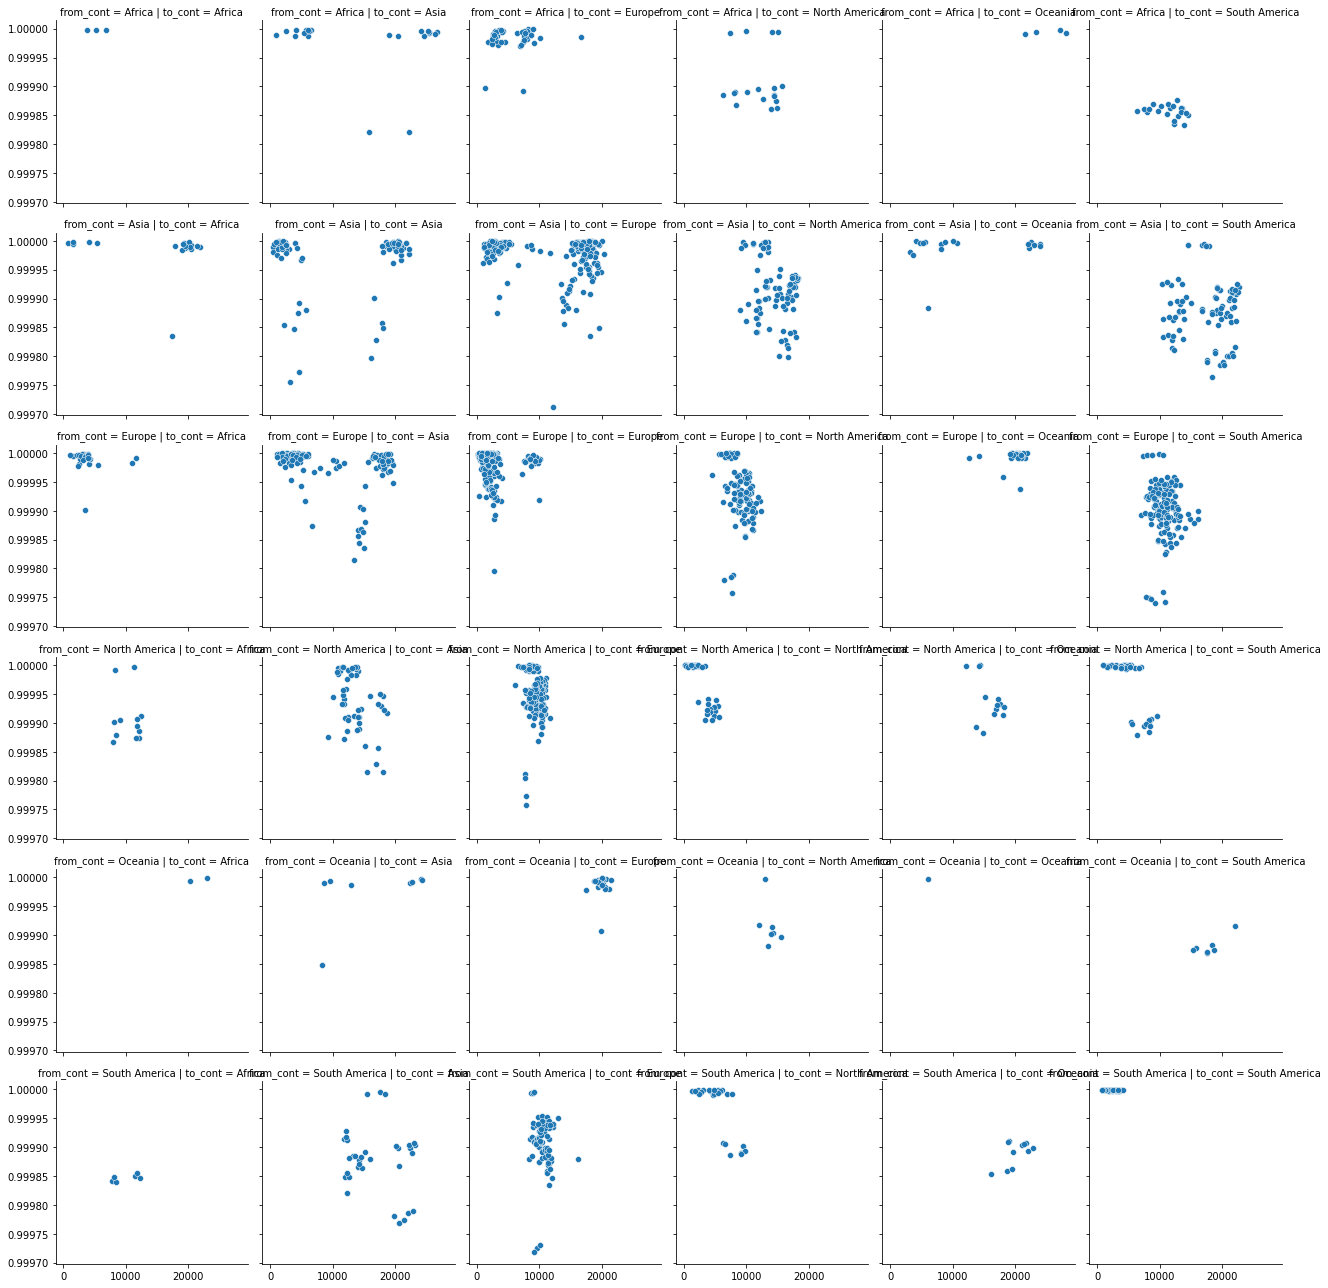

In [93]:
g = sns.FacetGrid(data=cossim_small, row='from_cont', col='to_cont')
g.map_dataframe(sns.scatterplot, x='distance', y='sim')

<AxesSubplot:xlabel='distance', ylabel='sim'>

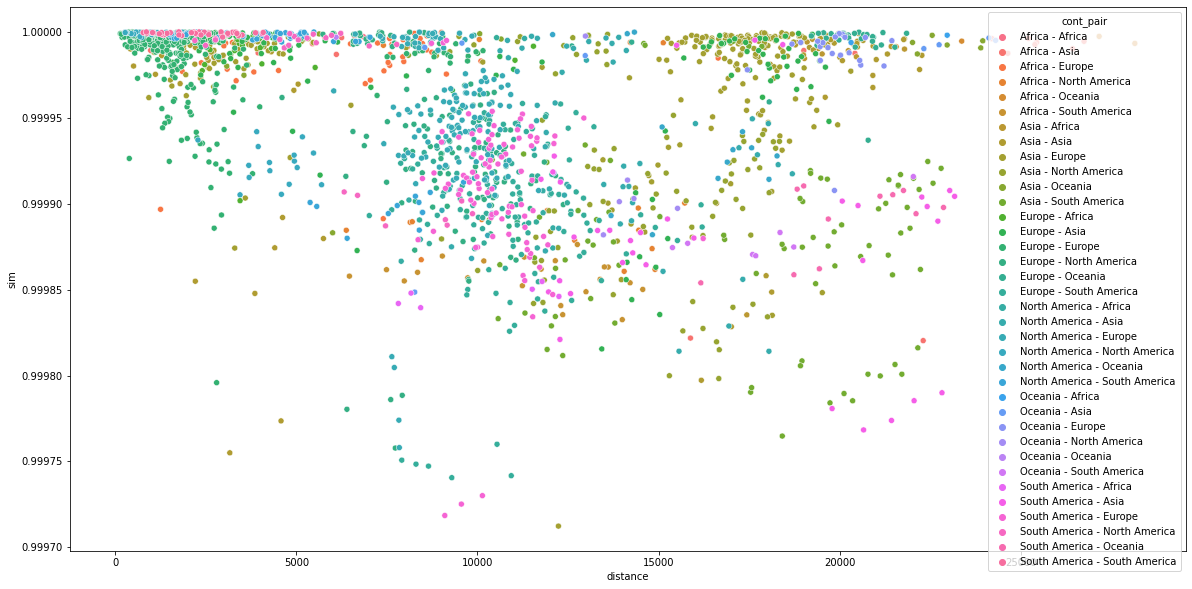

In [95]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=cossim_small.sort_values('cont_pair'),
                x='distance', y='sim', hue='cont_pair')


* usredniony wektor cech dla państwa po tygodniach i jego odległość kosinusowa z innymi krajami w danym tygodniu

* jak zmieniała się taka odległość między państwami (czy kraje się od siebie zbliżają albo oddalają?)

<AxesSubplot:xlabel='date', ylabel='sims'>

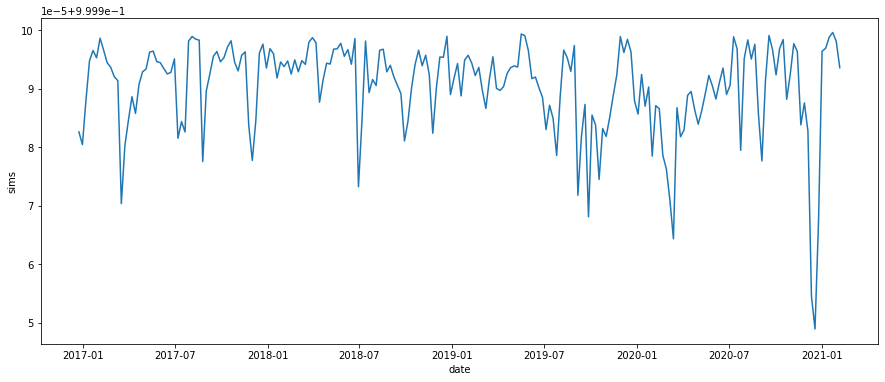

In [96]:
pl_us_features = chart_data_totals_features \
    .filter((F.col('Country') == 'pl') | (F.col('Country') == 'us')) \
    .toPandas()

sims = []
dates = []

for gname, gdf in pl_us_features.groupby('Date'):
    sims.append(cosine_similarity(gdf.drop(['Country', 'Date'], axis=1))[0,1])
    dates.append(gname)

pl_us_sim = pd.DataFrame({'date': pd.to_datetime(dates), 'sims': sims})

plt.figure(figsize=(15,6))
sns.lineplot(data=pl_us_sim, x='date', y='sims')

### Gatunek a cechy audio

* boxplot per gatunek (z top najpipularniejszych + ręcznie wybrane)

In [145]:
genre_features = chart_data \
    .select('TrackID') \
    .drop_duplicates() \
    .join(track_data, chart_data['TrackID'] == track_data['item_id']) \
    .join(artist_data.select(['id', 'genre']), track_data['track_artist_id'] == artist_data['id']) \
    .filter(F.col('genre') != '[]') \
    .filter(F.col('album_release_year') >= 1900) \
    .select('genre', 'album_release_year', 'acousticness', 'danceability',
            'energy', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness',
            'tempo', 'valence', 'track_duration_ms', 'track_explict', 'track_popularity') \
    .toPandas()

In [148]:
genre_features['big_genre'] = genre_features['genre'].map(di)

genres_for_plot = list(genre_features.value_counts('big_genre').head(20).index) + ['metal', 'jazz', 'alternative', 'poezja spiewana', 'disco polo',
                                                                                   'polish alternative', 'polish alternative rap', 'polish alternative rock',
                                                                                   'polish electronica', 'metal', 'classical', 'jazz', 'disco polo']
genre_features = genre_features[genre_features['big_genre'].isin(set(genres_for_plot))]
genre_features_melt = genre_features.melt(id_vars=['genre', 'big_genre'])

genre_features_melt['value'] = genre_features_melt['value'].apply(lambda s: float(s))

genre_features_melt_plot = genre_features_melt.groupby(['big_genre', 'variable']).aggregate(
    mean=pd.NamedAgg(column='value', aggfunc='mean'), 
    median=pd.NamedAgg(column='value', aggfunc='median')
).reset_index()

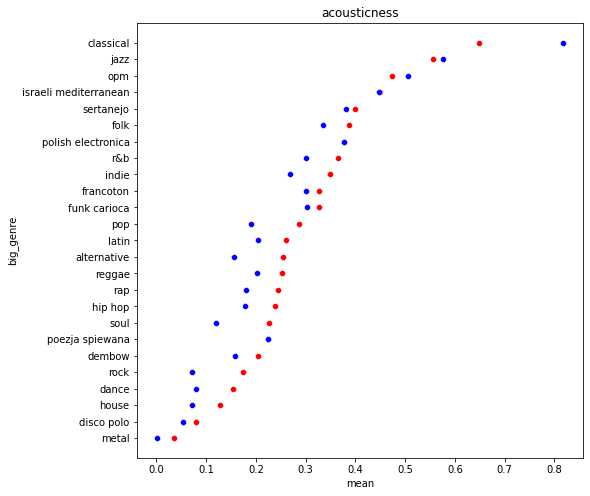

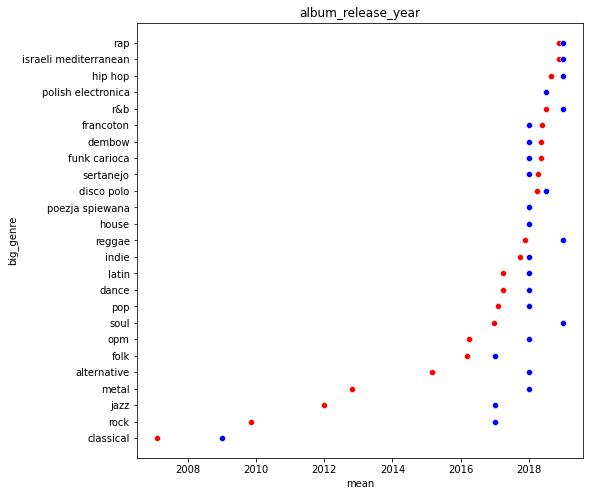

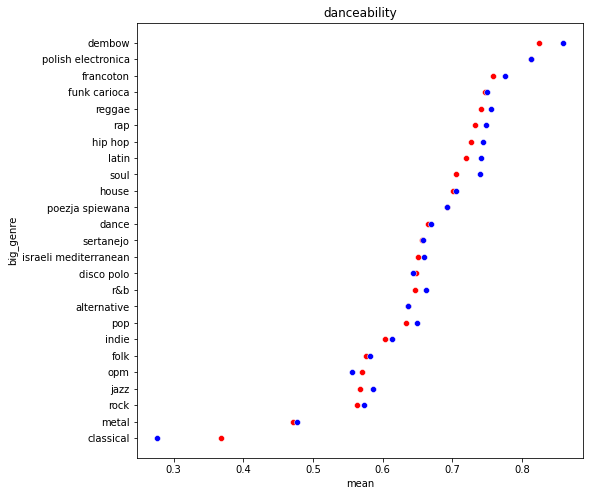

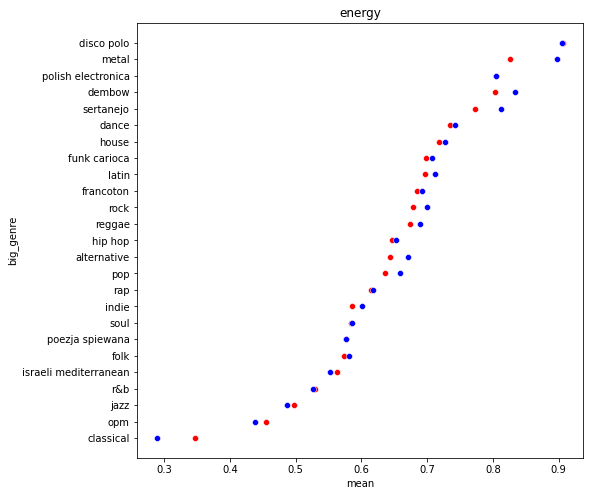

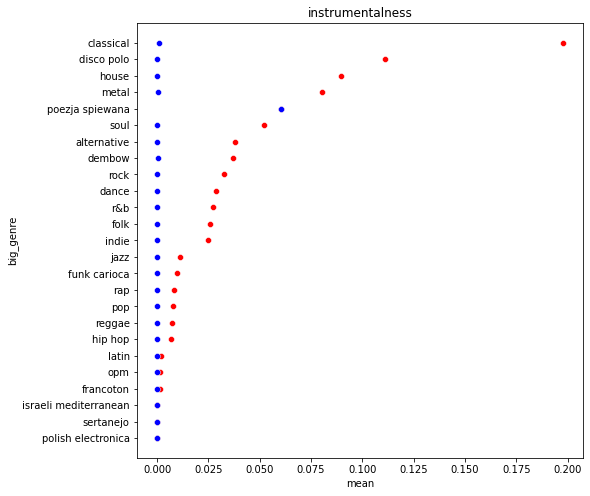

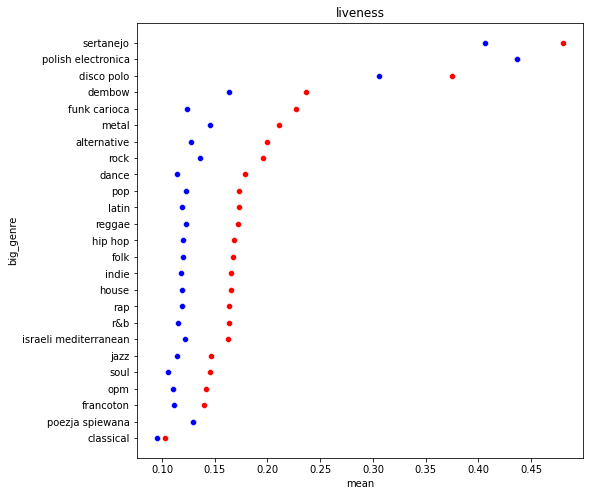

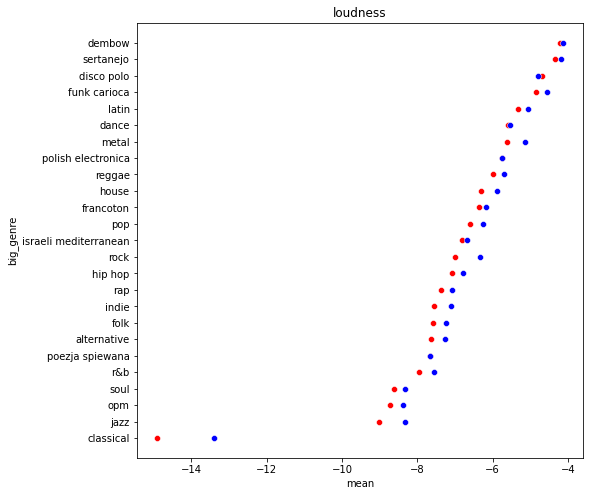

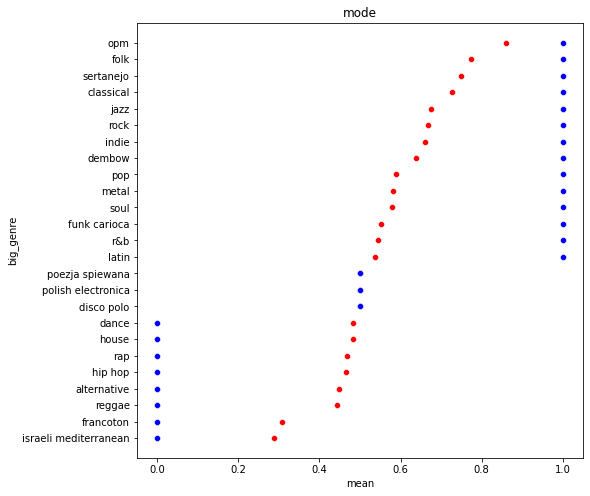

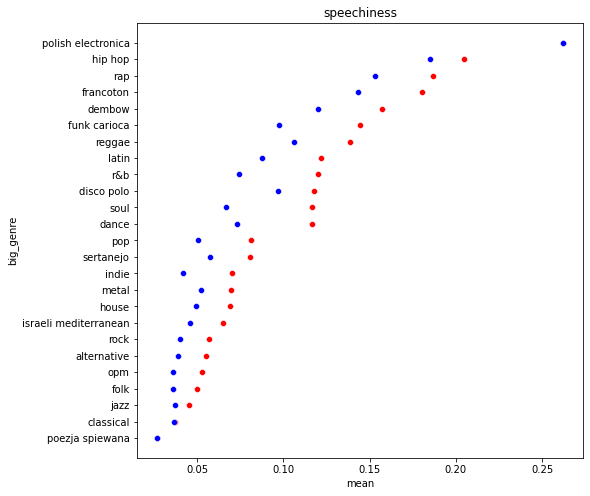

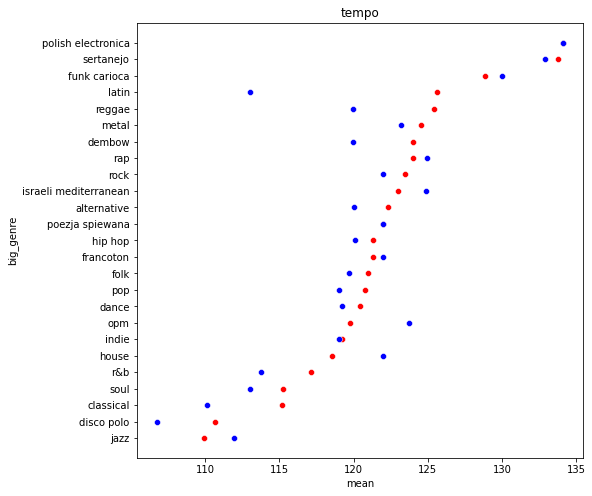

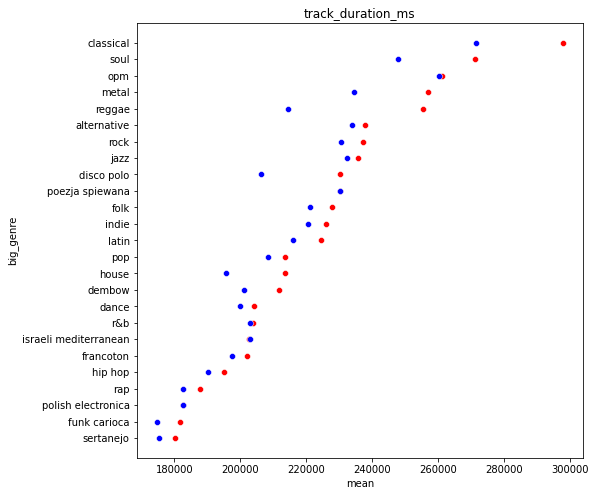

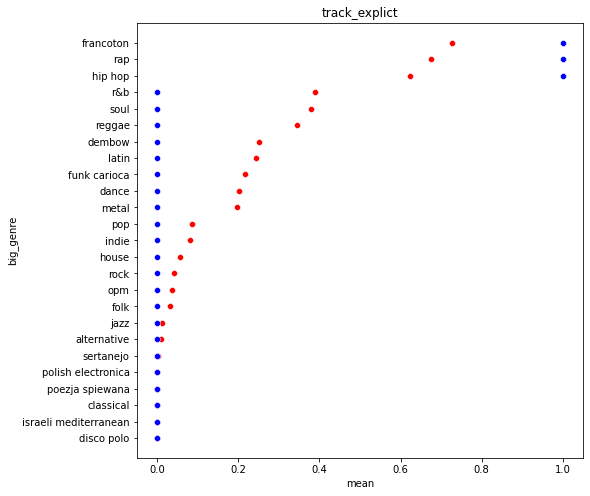

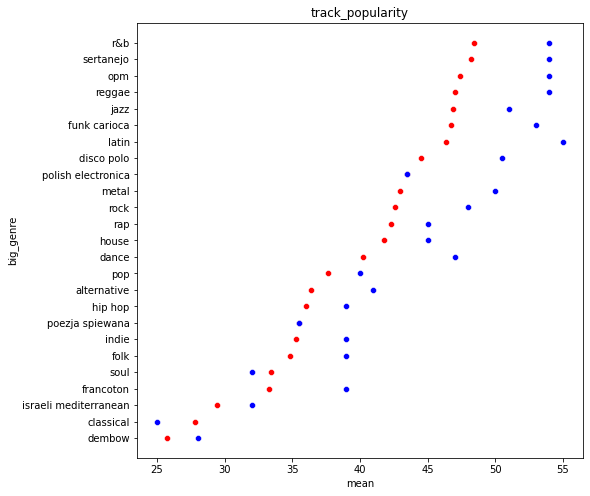

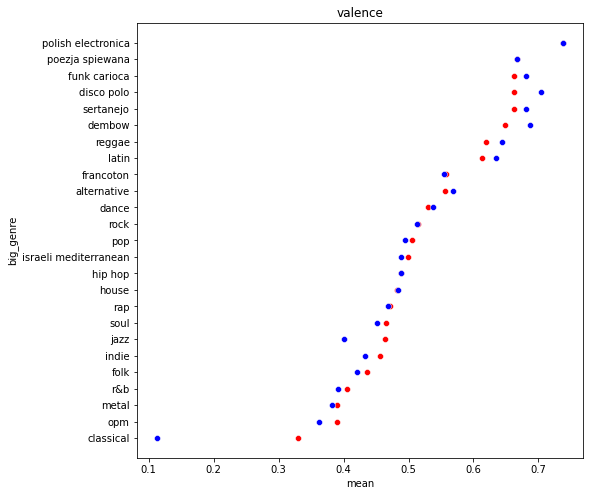

In [178]:
for gn,gdf in genre_features_melt_plot.groupby('variable'):
    gdf.sort_values('mean', ascending=False, inplace=True)
    plt.figure(figsize=(8,8))
    sns.scatterplot(data=gdf, x='mean', y='big_genre', color='r')
    sns.scatterplot(data=gdf, x='median', y='big_genre', color='b')
    plt.title(gn)

## Top Wszech Czasów

* punktacja za miejsce na liście (1 miejsce = 200 pkt, 200 miejsce = 1 pkt)
  * globalnie
  * US, UK, PL

In [187]:
chart_data_points = chart_data \
    .withColumn('points', 201 - F.col('Position')) \
    .withColumn('year', F.year(F.to_date('Date'))) \
    .groupBy('Country', 'year', 'Artist', 'TrackName') \
    .agg(F.sum('points').alias('points')) \
    .sort(F.col('points').desc()) \
    .toPandas()

In [211]:
chart_data_points_global = chart_data_points.groupby(['year', 'Artist']).aggregate({'points': 'sum'}).reset_index().sort_values('points', ascending=False)

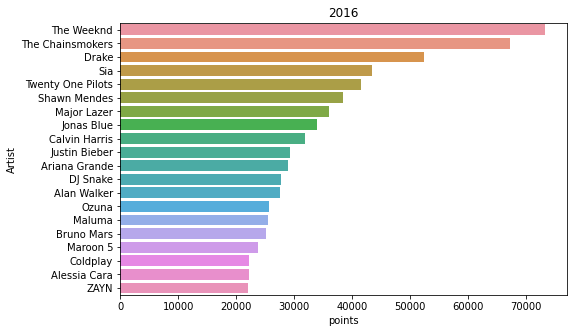

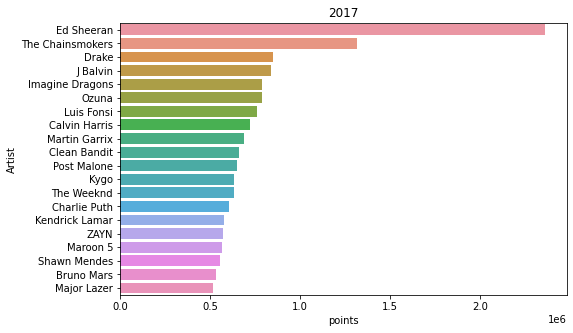

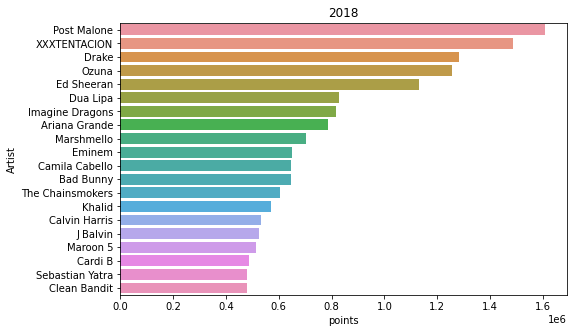

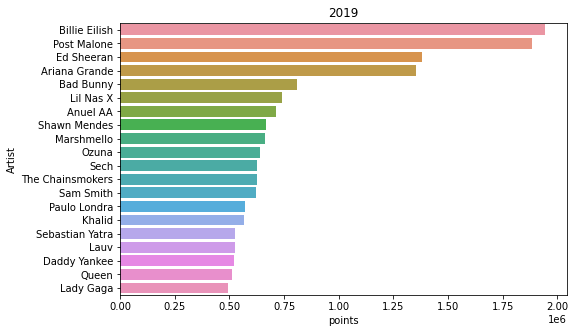

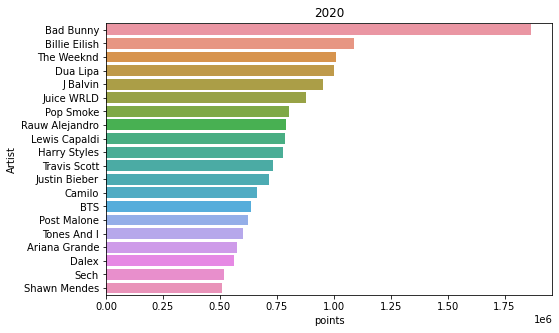

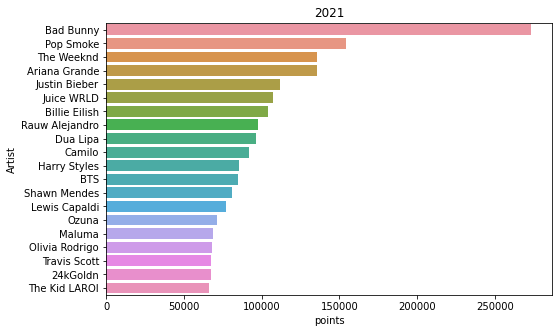

In [244]:
for gn,gdf in chart_data_points_global.groupby('year'):
    gdf = gdf.sort_values('points', ascending=False).head(20)
    plt.figure(figsize=(8,5))
    sns.barplot(data=gdf, x='points', y='Artist')
    plt.title(gn)

In [241]:
chart_data_points_pl = chart_data_points[chart_data_points['Country'] == 'pl'].groupby(['year', 'Artist']).aggregate({'points': 'sum'}).reset_index().sort_values('points', ascending=False)

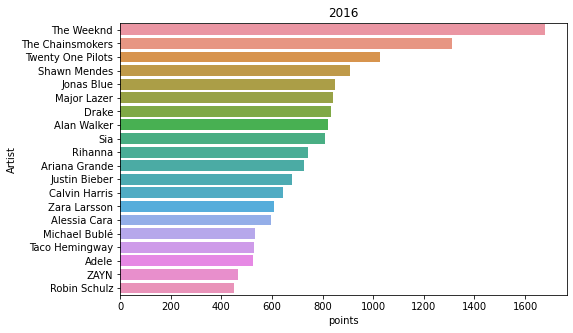

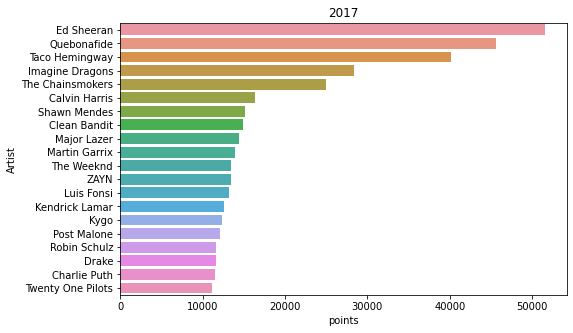

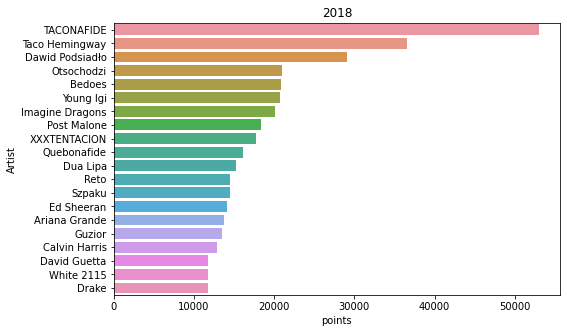

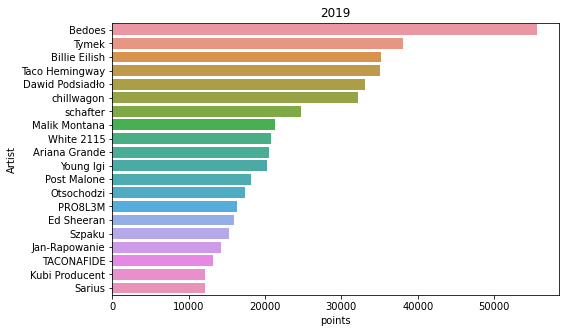

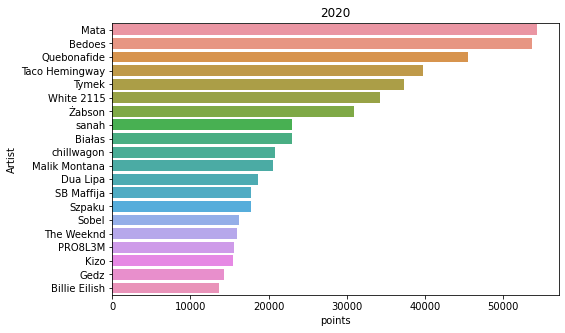

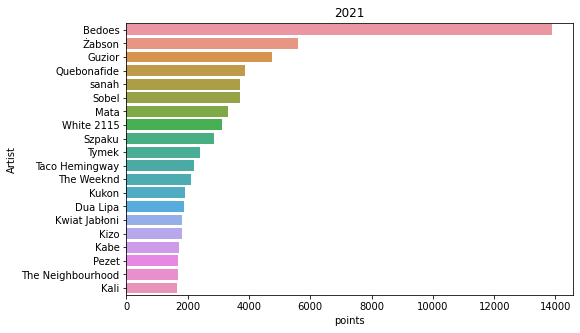

In [245]:
for gn,gdf in chart_data_points_pl.groupby('year'):
    gdf = gdf.sort_values('points', ascending=False).head(20)
    plt.figure(figsize=(8,5))
    sns.barplot(data=gdf, x='points', y='Artist')
    plt.title(gn)

## Wejście do top5

* ile czasu zajmuje od premiery do pojawienia się w top200?

* w szczególności dla piosenek z pierwszego miejsca
 * czy to się różni US / UK vs PL?
 * pierwszy moment pojawienia się w top - jak długo czasu i na które miejsce?

* ile % streamów zgrania top1? ole top3?

In [261]:
top_streams = chart_data \
    .withColumn('year', F.year(F.to_date('Date'))) \
    .groupBy('Country', 'year', 'Position') \
    .agg(F.sum('Streams').alias('Streams')) \
    .sort(F.col('Streams').desc()) \
    .toPandas()

In [264]:
top_streams['Streams_totals'] = top_streams.groupby(['Country', 'year'])['Streams'].transform('sum')

In [265]:
top_streams['percent'] = 100 * top_streams['Streams'] / top_streams['Streams_totals']

<AxesSubplot:xlabel='Position', ylabel='percent'>

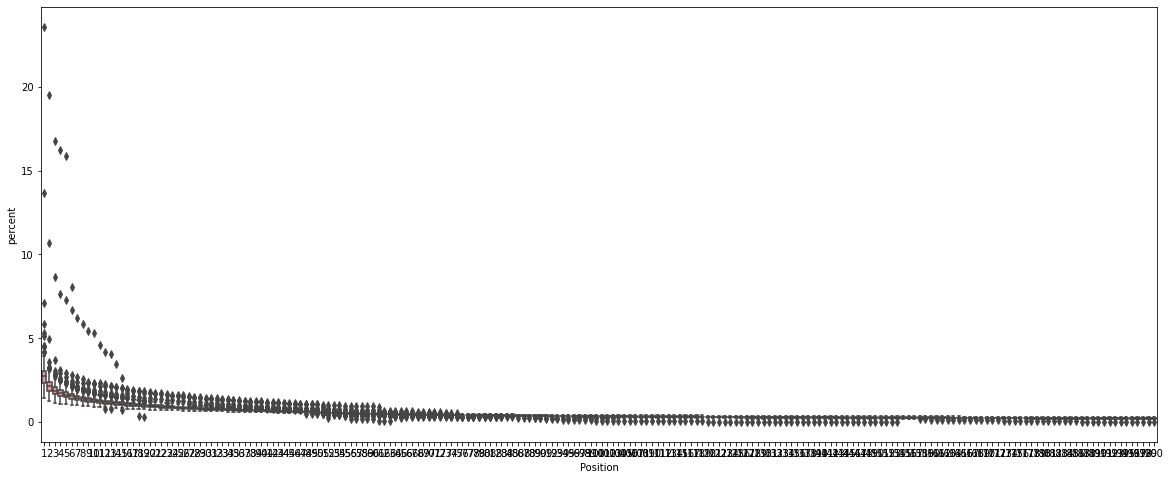

In [269]:
plt.figure(figsize=(20,8))
sns.boxplot(data=top_streams, x='Position', y='percent')

In [274]:
top_streams_cumsum = top_streams.groupby('Position').aggregate({'percent':'mean'}).reset_index().sort_values('Position', ascending=True)
top_streams_cumsum['cumsum_percent'] = top_streams_cumsum['percent'].cumsum()


<AxesSubplot:xlabel='Position', ylabel='cumsum_percent'>

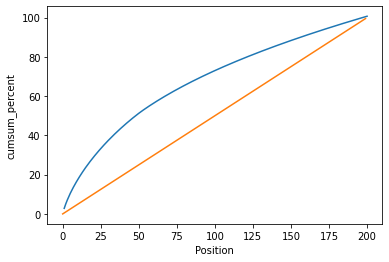

In [278]:
sns.lineplot(data=top_streams_cumsum, x='Position', y='cumsum_percent')

* popularity pioseniki vs łączna liczba streamów

In [287]:
popularity_vs_streams = chart_data_totals.groupby('track_popularity').agg(F.mean('Streams_total').alias('mean_streams')).toPandas()

<AxesSubplot:xlabel='track_popularity', ylabel='mean_streams'>

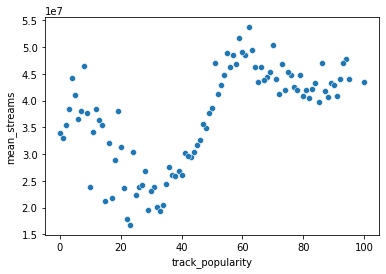

In [288]:
sns.scatterplot(data=popularity_vs_streams, x='track_popularity', y='mean_streams')

## Boże Narodzenie

* jacy artyści są popularni?

In [66]:
streams_per_track_month = charts_with_tracks \
    .filter(F.col('album_release_year') != 0) \
    .filter(F.col('album_release_year') < 2016) \
    .withColumn('Date', F.to_date('Date')) \
    .withColumn('month', F.month('Date')) \
    .groupBy('Date', 'TrackName', 'Artist', 'month') \
    .agg(F.sum('Streams').alias('Streams')) \
    .sort('Artist', 'TrackName') \
    .toPandas()

In [67]:
# szukamy piosenek, które w miesiącach blisko Bożego Narodzenia robią co najmniej 50% swoich odtworzeń
streams_per_track_month['streams_per_month'] = streams_per_track_month.groupby(['TrackName', 'Artist', 'month'])['Streams'].transform('sum')
streams_per_track_month['streams_total'] = streams_per_track_month.groupby(['TrackName', 'Artist'])['Streams'].transform('sum')
streams_per_track_month['percent'] = 100 * streams_per_track_month['streams_per_month'] / streams_per_track_month['streams_total']

xmas_songs = streams_per_track_month[(streams_per_track_month['month'].isin([11, 12, 1])) & (streams_per_track_month['percent'] >= 50)]
xmas_songs["ArtistTitle"] = xmas_songs['TrackName'] + ' - ' + xmas_songs['Artist']

xmas_top50 = xmas_songs[xmas_songs['month'] == 12][['TrackName', 'Artist', 'streams_total']] \
    .drop_duplicates() \
    .sort_values('streams_total', ascending=False)

xmas_top50.head(20)

<ipython-input-67-342a2da04395>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xmas_songs["ArtistTitle"] = xmas_songs['TrackName'] + ' - ' + xmas_songs['Artist']


,TrackName,Artist,streams_total
63603,All I Want for Christmas Is You,Mariah Carey,613057009
100757,Last Christmas,Wham!,467632402
6284,Santa Tell Me,Ariana Grande,348446459
65860,It's Beginning to Look a Lot like Christmas,Michael Bublé,320038961
5084,It's the Most Wonderful Time of the Year,Andy Williams,275096879
10135,Jingle Bell Rock,Bobby Helms,272640850
10413,Rockin' Around The Christmas Tree,Brenda Lee,249903741
49363,Mistletoe,Justin Bieber,229420032
8137,Do They Know It's Christmas? - 1984 Version,Band Aid,225102936
31160,Let It Snow! Let It Snow! Let It Snow! (with T...,Frank Sinatra,193608461


* kiedy zaczyna się granie "Last Christmas" i innych podobnych piosenek?

In [68]:
xmas_plot = xmas_songs[xmas_songs['TrackName'].isin(xmas_top50['TrackName'])]

xmas_plot['Date'] = xmas_plot['Date'].apply(lambda x: x.replace(year=2020))

<ipython-input-68-352b9e3e46c3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xmas_plot['Date'] = xmas_plot['Date'].apply(lambda x: x.replace(year=2020))


<AxesSubplot:xlabel='Date', ylabel='Streams'>

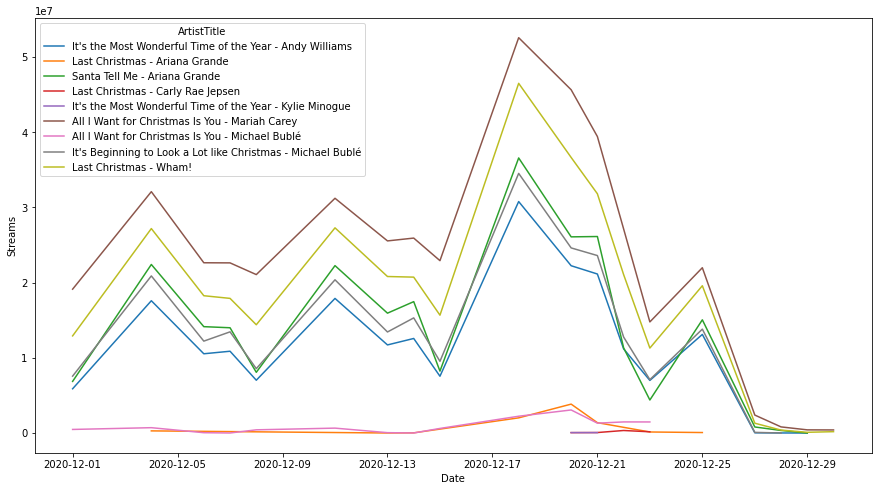

In [69]:
plt.figure(figsize=(15,8))
sns.lineplot(data=xmas_plot[xmas_plot['TrackName'].isin(xmas_top50['TrackName'][:5])],
             x='Date', y='Streams', hue='ArtistTitle')


* jak wyglądają cechy w lecie vs zima

## Kasa
* Ile kasy zgadnie artysta?
  * stawki za https://www.visualcapitalist.com/how-many-music-streams-to-earn-a-dollar/

# PowerBI